# SKIN CANCER MNIST: HAM10000 CLASSIFICATION USING K-MEANS


## Assignment 3 - Data Exploration and Feature Extraction <br>
## Assignment 4 - KNN Feature Extraction and K - Means Models

## Dataset

Dataset consists of 10,015 images of skin lesions.  It is known as Human Against Machine with 10000 training images (HAM10000).  It was obtained from Kaggle, however the original dataset can be downloaded from here:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

The HAM10000 dataset served as the training set for the ISIC 2018 challenge.  It is a well known dataset for training machine learning classification models.  

Dataset consists of 3 files as follows: <br>
HAM10000_images_part1.zip (5000 JPEG files) <br>
HAM10000_images_part2.zip (5015 JPEG files) <br>
HAM10000_images_metadata.csv

there are also several supplementary files which are flattened image files: <br>
hmnist_28_28_L.csv <br>
hmnist_28_28_RGB.csv <br>
hmnist_8_8_L.csv <br>
hmnist_8_8_RGB.csv <br>

The metadata file provides: <br>
lesion_id - there are a total of 7470 unique lesions<br>
image_id - there are a total of 10,015 unique images <br>
dx - Diagnosis - there are 7 classes of skin lesions (ground truth) in the dataset: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc). <br>
dx_type - histopathology (histo), follow-up examination (followup), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal) <br>
age - numerical range from 0-85 </br>
sex - categorical variable male/female/other <br>
localization - categorical variable describing part of the body where lesion was located


## INITIAL DATA EXPLORATION

Lets do some preliminary exploration of the data.  Below, we first imported various Python libraries that would allow us to transform the data and get some basic statistics.  Then we imported the metadata file containing the demographic information (age, gender, lesion location) as well as the diagnosis and the method diagnosis was confirmed (histo is considered the most decisive method).    

In [1]:
#install one of the libraries
import sys
!{sys.executable} -m pip install scikit-image

In [2]:
#load libraries 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
import statistics
import glob
import cv2
import csv
import math
import os
import string
from skimage.color import rgb2gray
from PIL import Image
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics.cluster import adjusted_rand_score
import seaborn as sns


In [3]:
#load the flattened dataset that was used to study pixel intensity initially (before merge with metadata file)
df=pd.read_csv('hmnist_28_28_L.csv')
df.head(5)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
0,169,171,170,177,181,182,181,185,194,192,...,184,186,185,180,157,140,140,159,165,2
1,19,57,105,140,149,148,144,155,170,170,...,172,175,160,144,114,89,47,18,18,2
2,155,163,161,167,167,172,155,152,165,175,...,163,178,157,166,167,148,141,136,115,2
3,25,71,116,139,136,153,148,161,172,162,...,125,135,138,137,111,71,32,16,16,2
4,129,162,181,196,205,208,205,213,225,224,...,210,197,172,190,195,193,181,147,88,2


In [4]:
#load meta data file and make a copy of it (as to not corrupt the original data) and look at the first 5 rows
dfMeta=pd.read_csv('HAM10000_metadata (1).csv')
dfMeta.head(5)
dfOutput = dfMeta.copy()
dfOutput.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Now we are going to use a loop to add vectorized RGB and Grayscale values of each image to the dataframe

In [5]:
# Append a column for RGB array and GrayScale array to output
dfOutput['RGB'] = ""
dfOutput['GrayScale'] = ""
dfOutput['RGB'] = dfOutput['RGB'].astype(object)
dfOutput['GrayScale'] = dfOutput['GrayScale'].astype(object)

dfOutput.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,RGB,GrayScale
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,,
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,,
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,,
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,,
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,,


In [6]:
# Convert the RGB image to grayscale image
# loop the meta dataframe
# read the file name from dataframe

for ind in dfOutput.index:

    im2 = cv2.imread("images\\" + dfMeta.iloc[ind, 1] + '.jpg')
    gray2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)   # RGB -> Grayscale
    # flatten the array
    im2Flatten = im2.flatten()
    grayFlatten = gray2.flatten()
    # print(type(im2Flatten))
    # print(type(grayFlatten))
    dfOutput.at[ind, 'RGB'] = im2.flatten()
    dfOutput.at[ind, 'GrayScale'] = gray2.flatten()
    # dfOutput.loc[ind, 7] = im2Flatten
    # dfOutput.loc[ind, 8] = grayFlatten
    #print("images\\" + dfMeta.iloc[ind, 1] + '.jpg')  
    

In [7]:
dfOutput.head(5)  

,lesion_id,image_id,dx,dx_type,age,sex,localization,RGB,GrayScale
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,"[191, 147, 188, 189, 148, 186, 191, 150, 187, ...","[164, 164, 166, 167, 168, 171, 170, 171, 171, ..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,"[23, 15, 25, 22, 14, 25, 22, 14, 25, 22, 14, 2...","[19, 18, 18, 18, 18, 19, 19, 17, 16, 18, 18, 1..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,"[140, 128, 186, 136, 128, 188, 133, 126, 183, ...","[147, 147, 144, 147, 149, 151, 152, 155, 157, ..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,"[16, 9, 24, 15, 11, 22, 15, 11, 23, 16, 11, 26...","[14, 15, 15, 16, 15, 16, 15, 16, 16, 16, 18, 1..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,"[102, 80, 122, 104, 82, 124, 106, 83, 127, 109...","[95, 97, 99, 102, 105, 107, 109, 110, 113, 115..."


We can see that our dataframe is now properly merged and that flattened RGB and Grayscale values are added to the dataframe as an array

In [8]:
#get descriptive statistics
dfOutput.describe()  #age is the only numerical variable

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


Lets visualize some of the demographic characteristics of the patients represented in this dataset.  We see that the average age is 51.86 years overall but are there differences in the age distribution between different types of skin lesions?

Text(0.5, 1.0, 'Age Distribution')

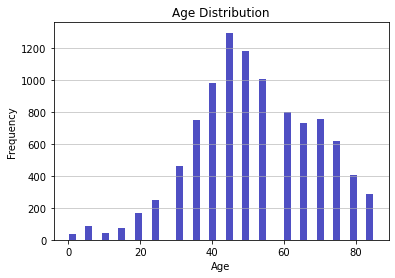

In [9]:
#plot age distribution on complete dataset

import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=dfOutput.age, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')


C:\Users\Tanja\anaconda3\envs\CPSC_4830\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Tanja\anaconda3\envs\CPSC_4830\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Tanja\anaconda3\envs\CPSC_4830\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

<Figure size 432x288 with 0 Axes>

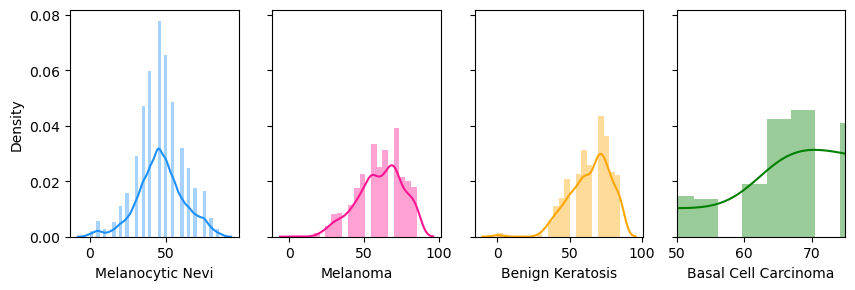

In [10]:
#age distribution for the 4 most common conditions

# Import data
df1 = dfOutput
x1 = df1.loc[df1.dx=='nv', ['age']]
x2 = df1.loc[df1.dx=='mel', ['age']]
x3 = df1.loc[df1.dx=='bkl',['age']]
x4 = df1.loc[df1.dx=='bcc',['age']]


# plot
plt.suptitle('Age Distribution for Different Types of Skin Lesions');
fig, axes = plt.subplots(1,4 , figsize=(10, 3), sharey=True, dpi=100)
sns.distplot(x1 , color="dodgerblue", ax=axes[0], axlabel='Melanocytic Nevi')
sns.distplot(x2 , color="deeppink", ax=axes[1], axlabel='Melanoma')
sns.distplot(x3 , color="orange", ax=axes[2], axlabel='Benign Keratosis')
sns.distplot(x4 , color="green", ax=axes[3], axlabel='Basal Cell Carcinoma')
plt.xlim(50,75);

Are there any differences in the incidence of these lesions by gender?

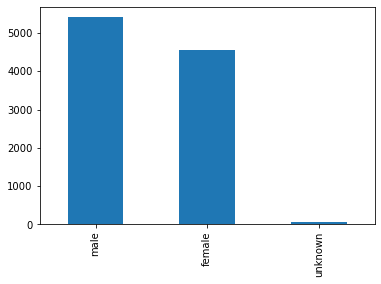

In [11]:
#plot bar graph of gender
dfOutput['sex'].value_counts().plot(kind='bar');

<AxesSubplot:xlabel='count', ylabel='dx'>

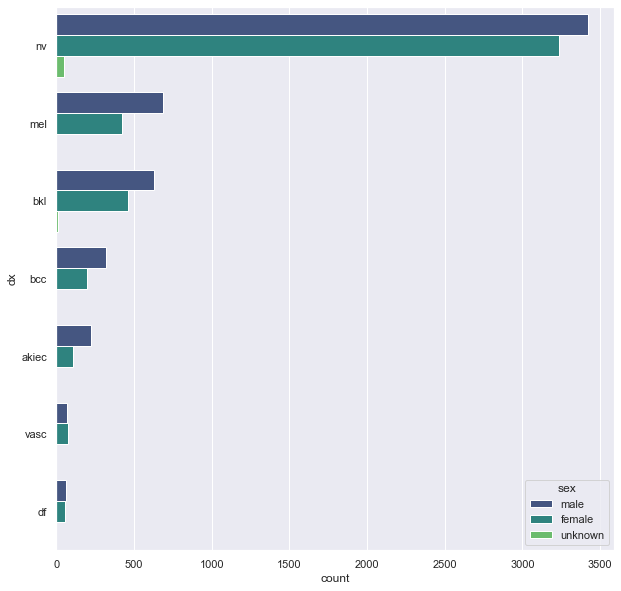

In [12]:
#plot of gender per diagnosis
sns.set(rc={'figure.figsize':(10,10)})

sns.countplot(y='dx',order=['nv','mel','bkl','bcc','akiec','vasc','df'], data=dfOutput, palette='viridis', hue='sex')

We see that one of the categories has a lot more data points than the others, lets look at the counts of each diagnosis in a dataset

In [13]:
#look at how many images are in each category (diagnosis)
dfOutput.groupby('dx').count()

,lesion_id,image_id,dx_type,age,sex,localization,RGB,GrayScale
dx,,,,,,,,
akiec,327,327,327,327,327,327,327,327
bcc,514,514,514,514,514,514,514,514
bkl,1099,1099,1099,1089,1099,1099,1099,1099
df,115,115,115,115,115,115,115,115
mel,1113,1113,1113,1111,1113,1113,1113,1113
nv,6705,6705,6705,6660,6705,6705,6705,6705
vasc,142,142,142,142,142,142,142,142


As we can see from the above, the dataset is not very balanced, the number of images varies greatly between different categories of diagnosis.  It was therefore decided to drop the under-respresented types of lesions and only focus on 4 categories - 2 malignant and 2 benign. Below, we split the data based on the diagnosis into separate dataframes. We also decided to randomly sample 1,100 images from the Melanocytic nevi (nv) category and only use those in our model to make the dataset more balanced

Important thing to note here is that below basic statistics were done before we wrote the code to merge the metadata file and images.  They were done using the 28 X 28 Grayscale file with pixels as columns.

In [14]:
#split dataset into 4 different dataframes based on the diagnosis
df_carcinoma=df[df['label']==1]
df_bkl=df[df['label']==2]
df_mn=df[df['label']==4]
df_melanoma=df[df['label']==6]

In [15]:
df_mn.count()

pixel0000    6705
pixel0001    6705
pixel0002    6705
pixel0003    6705
pixel0004    6705
             ... 
pixel0780    6705
pixel0781    6705
pixel0782    6705
pixel0783    6705
label        6705
Length: 785, dtype: int64

From here on, all the procedures that we are applying will be repeated for each of the 4 types of skin leasions that we decided to include in our model.

## 1.  Basal Cell Carcinoma

In [16]:
# Basic Statistics 
df_carcinoma.describe()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
count,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,...,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.0
mean,142.474708,151.447471,159.025292,163.750973,166.478599,169.208171,171.628405,173.856031,174.651751,175.268482,...,170.772374,169.132296,166.912451,164.272374,161.077821,156.429961,149.571984,140.449416,131.920233,1.0
std,49.722116,42.059854,35.281676,30.729916,27.837396,25.152429,23.285332,22.207481,20.959381,20.898667,...,24.884386,25.004054,25.544482,27.294219,30.076863,35.087248,41.748617,49.073625,55.320645,0.0
min,0.000000,0.000000,2.000000,6.000000,12.000000,46.000000,80.000000,81.000000,97.000000,95.000000,...,12.000000,19.000000,51.000000,40.000000,24.000000,20.000000,6.000000,2.000000,0.000000,1.0
25%,124.000000,135.000000,145.000000,149.000000,152.000000,155.250000,158.250000,161.000000,163.000000,162.250000,...,157.000000,155.250000,154.000000,147.000000,146.000000,142.000000,134.250000,124.250000,113.000000,1.0
50%,157.000000,161.000000,165.000000,168.000000,171.000000,173.000000,174.000000,175.000000,176.000000,176.000000,...,173.000000,172.000000,171.000000,169.000000,166.000000,164.000000,159.000000,152.500000,148.000000,1.0
75%,176.000000,179.000000,182.000000,183.000000,185.000000,187.000000,187.000000,189.000000,189.000000,190.000000,...,187.750000,185.750000,183.000000,182.000000,181.000000,179.000000,176.750000,173.000000,170.000000,1.0
max,233.000000,230.000000,232.000000,232.000000,230.000000,233.000000,234.000000,234.000000,232.000000,235.000000,...,232.000000,227.000000,224.000000,228.000000,224.000000,222.000000,227.000000,223.000000,219.000000,1.0


In [17]:
#pick up the means for each pixel
av_carc=df_carcinoma.mean(axis=0)
av_carc

pixel0000    142.474708
pixel0001    151.447471
pixel0002    159.025292
pixel0003    163.750973
pixel0004    166.478599
                ...    
pixel0780    156.429961
pixel0781    149.571984
pixel0782    140.449416
pixel0783    131.920233
label          1.000000
Length: 785, dtype: float64

In [18]:
#get rid of the label column
pixels_carc=av_carc[0:784]
pixels_carc

pixel0000    142.474708
pixel0001    151.447471
pixel0002    159.025292
pixel0003    163.750973
pixel0004    166.478599
                ...    
pixel0779    161.077821
pixel0780    156.429961
pixel0781    149.571984
pixel0782    140.449416
pixel0783    131.920233
Length: 784, dtype: float64

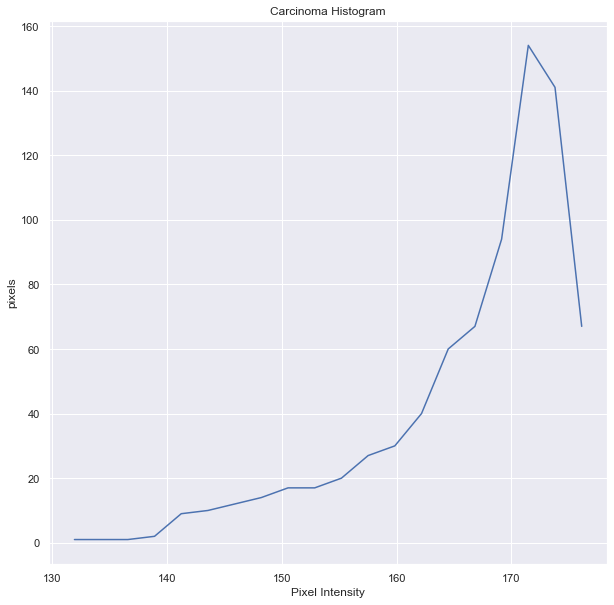

In [19]:
# Histogram of mean values of each pixel
histogram, bin_edges= np.histogram(pixels_carc,bins=20)
plt.plot(bin_edges[0:-1],histogram)
plt.title("Carcinoma Histogram")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [20]:
#Find kurtosis of the histogram
kurt_carc = kurtosis(pixels_carc, fisher=False)
kurt_carc

4.396915883806542

In [21]:
#Find Skewness of the histogram
skew_carc = skew(pixels_carc)
skew_carc

-1.3618534010013699

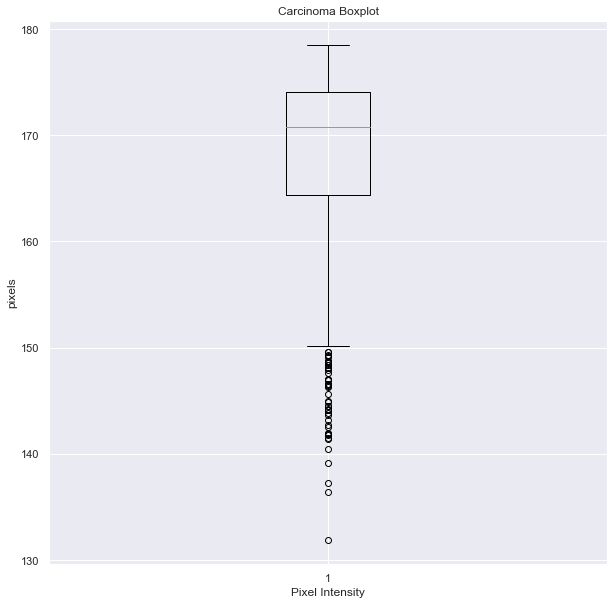

In [22]:
#Create a box plot
plt.boxplot(pixels_carc)
plt.title("Carcinoma Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [23]:
# Computing First and Third Quartile
Q1_carc = pixels_carc.quantile(0.25)
Q3_carc = pixels_carc.quantile(0.75)

Q1_carc,Q3_carc

(164.3317120622568, 174.02772373540856)

In [24]:
#Computing mean
mean_carc = statistics.mean(pixels_carc)
mean_carc

167.8610413523386

In [25]:
#Computing standard deviation
sd_carc = statistics.stdev(pixels_carc)
sd_carc

8.622548096732332

## 2.  Benign Keratosis

In [26]:
# Basic Statistics
df_bkl.describe()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
count,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,...,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.0
mean,127.044586,134.572338,141.916288,147.786169,152.607825,156.636033,159.797088,161.817106,163.469518,164.577798,...,158.586897,156.734304,154.548681,151.876251,148.361237,142.708826,135.993631,127.997270,119.348499,2.0
std,54.782205,50.850123,45.634130,40.792008,36.512492,32.389766,29.178050,27.337036,26.428198,25.544313,...,27.192601,28.693824,30.551789,32.392138,35.208999,39.934085,45.822586,51.049576,55.343155,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,6.000000,8.000000,...,21.000000,24.000000,0.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,103.000000,115.000000,124.000000,131.000000,136.000000,139.000000,143.000000,145.000000,147.000000,148.000000,...,141.000000,139.000000,137.000000,134.000000,130.000000,123.000000,115.500000,104.000000,92.000000,2.0
50%,139.000000,144.000000,149.000000,153.000000,156.000000,158.000000,161.000000,162.000000,164.000000,165.000000,...,158.000000,157.000000,156.000000,154.000000,151.000000,147.000000,144.000000,139.000000,132.000000,2.0
75%,166.000000,170.000000,172.000000,174.500000,176.000000,177.000000,178.000000,179.000000,179.500000,180.000000,...,177.000000,176.000000,175.000000,173.000000,172.000000,170.000000,167.000000,163.000000,160.000000,2.0
max,238.000000,238.000000,235.000000,235.000000,234.000000,239.000000,239.000000,240.000000,238.000000,237.000000,...,244.000000,245.000000,244.000000,242.000000,249.000000,247.000000,244.000000,243.000000,240.000000,2.0


In [27]:
#pick up the means for each pixel
av_bkl=df_bkl.mean(axis=0)
av_bkl

pixel0000    127.044586
pixel0001    134.572338
pixel0002    141.916288
pixel0003    147.786169
pixel0004    152.607825
                ...    
pixel0780    142.708826
pixel0781    135.993631
pixel0782    127.997270
pixel0783    119.348499
label          2.000000
Length: 785, dtype: float64

In [28]:
#get rid of the label column
pixels_bkl=av_bkl[0:784]
pixels_bkl

pixel0000    127.044586
pixel0001    134.572338
pixel0002    141.916288
pixel0003    147.786169
pixel0004    152.607825
                ...    
pixel0779    148.361237
pixel0780    142.708826
pixel0781    135.993631
pixel0782    127.997270
pixel0783    119.348499
Length: 784, dtype: float64

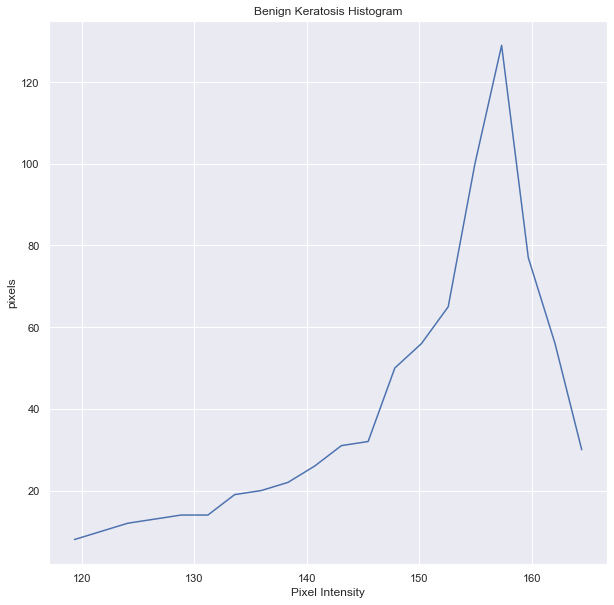

In [29]:
# Histogram of mean values of each pixel
histogram, bin_edges= np.histogram(pixels_bkl,bins=20)
plt.plot(bin_edges[0:-1],histogram)
plt.title("Benign Keratosis Histogram")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [30]:
#Find kurtosis of the histogram
kurt_bkl = kurtosis(pixels_bkl, fisher=False)
kurt_bkl

3.405378041175825

In [31]:
#Find Skewness of the histogram
skew_bkl = skew(pixels_bkl)
skew_bkl

-1.075407049741422

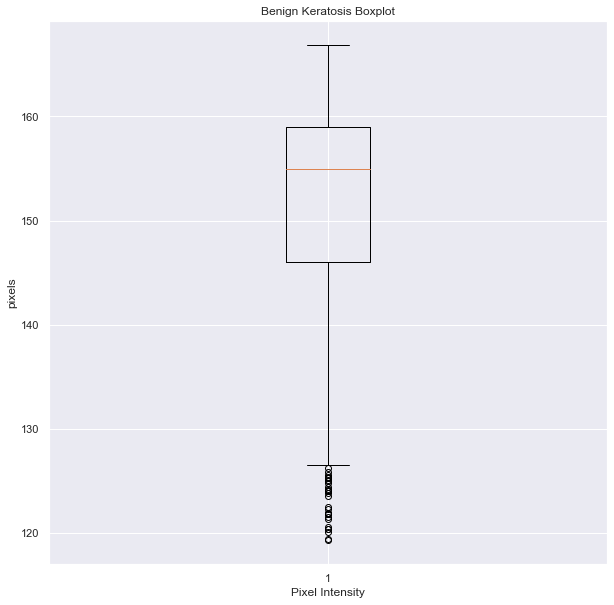

In [32]:
#Create a box plot
plt.boxplot(pixels_bkl)
plt.title("Benign Keratosis Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [33]:
# Computing 1st and 3rd Quartile
Q1_bkl = pixels_bkl.quantile(0.25)
Q3_bkl = pixels_bkl.quantile(0.75)

Q1_bkl,Q3_bkl


(146.00295723384897, 159.01205641492265)

In [34]:
#Computing mean
mean_bkl = statistics.mean(pixels_bkl)
mean_bkl

151.44817412861414

In [35]:
#Computing SD
sd_bkl = statistics.stdev(pixels_bkl)
sd_bkl

10.74575037284487

## 3.  Melanocytic Nevi

In [36]:
df_mn.info()  #we have 6705 rows whereas for other classes we have much less

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6705 entries, 64 to 9686
Columns: 785 entries, pixel0000 to label
dtypes: int64(785)
memory usage: 40.2 MB


From the info about the dataset we can see that for this class of diagnosis, there are 6,705 images which is much more than any other class.  Therefore, we decided to randomly sample 1,100 images from this class so that the number of datapoints is closer to the datasets for the other diagnoses

In [37]:
#randomly select 1100 datapoints and look at descriptive statistics

# only 625 entries, direct copy instead of sample
# df_mn_red = df_mn.sample(n=1100,random_state=142)
df_mn_red = df_mn
df_mn_red.describe()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
count,6705.000000,6705.000000,6705.000000,6705.000000,6705.000000,6705.000000,6705.000000,6705.000000,6705.000000,6705.000000,...,6705.000000,6705.000000,6705.000000,6705.000000,6705.000000,6705.000000,6705.000000,6705.000000,6705.000000,6705.0
mean,154.427890,158.798359,162.214914,164.558688,166.907233,168.958538,170.353766,171.497390,172.321551,172.944668,...,167.767189,167.048471,166.308277,165.271141,163.432215,160.433855,156.984191,153.074720,149.043997,4.0
std,42.190508,37.936500,34.492176,32.135966,29.308438,25.908759,24.232290,23.536172,23.008659,22.769548,...,23.303306,23.654128,24.083734,24.868854,26.697701,30.944564,35.654205,39.943441,42.623620,0.0
min,0.000000,0.000000,0.000000,0.000000,3.000000,7.000000,17.000000,16.000000,16.000000,18.000000,...,5.000000,9.000000,9.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0
25%,144.000000,147.000000,150.000000,152.000000,154.000000,155.000000,156.000000,158.000000,158.000000,159.000000,...,154.000000,153.000000,152.000000,151.000000,149.000000,147.000000,145.000000,142.000000,139.000000,4.0
50%,164.000000,166.000000,168.000000,169.000000,170.000000,171.000000,172.000000,173.000000,174.000000,174.000000,...,169.000000,168.000000,168.000000,167.000000,166.000000,164.000000,163.000000,161.000000,158.000000,4.0
75%,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,186.000000,186.000000,187.000000,188.000000,...,182.000000,182.000000,181.000000,181.000000,180.000000,178.000000,177.000000,176.000000,173.000000,4.0
max,242.000000,248.000000,252.000000,253.000000,255.000000,255.000000,254.000000,255.000000,255.000000,254.000000,...,251.000000,250.000000,251.000000,252.000000,250.000000,252.000000,254.000000,252.000000,251.000000,4.0


We first performed the same procedures as for Basal Cell and Benign Keratosis above on the full dataset for Melanocytic Nevi. Then we reperformed them on the sampled dataframe. We wanted to see if sampling would significantly distort the statistics we are getting.

### On full dataset for mn - 6705 rows

In [38]:
#pick up the means for each pixel
av_mn=df_mn.mean(axis=0)
av_mn

pixel0000    154.427890
pixel0001    158.798359
pixel0002    162.214914
pixel0003    164.558688
pixel0004    166.907233
                ...    
pixel0780    160.433855
pixel0781    156.984191
pixel0782    153.074720
pixel0783    149.043997
label          4.000000
Length: 785, dtype: float64

In [39]:
#get rid of the label column
pixels_mn=av_mn[0:784]
pixels_mn

pixel0000    154.427890
pixel0001    158.798359
pixel0002    162.214914
pixel0003    164.558688
pixel0004    166.907233
                ...    
pixel0779    163.432215
pixel0780    160.433855
pixel0781    156.984191
pixel0782    153.074720
pixel0783    149.043997
Length: 784, dtype: float64

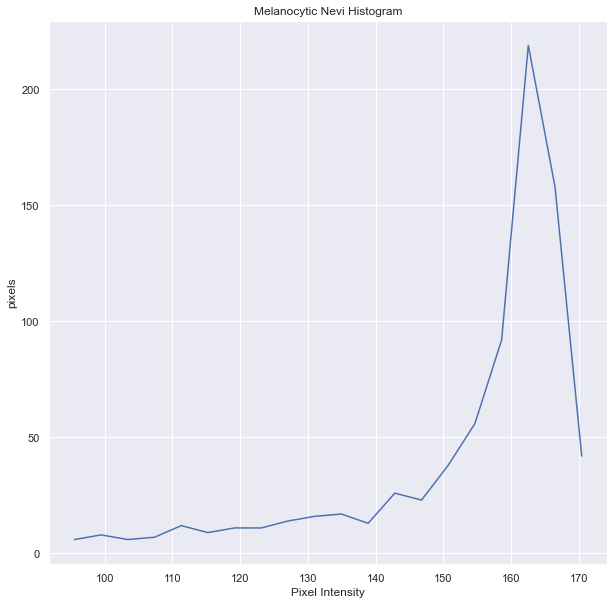

In [40]:
# Histogram of mean values of each pixel
histogram, bin_edges= np.histogram(pixels_mn,bins=20)
plt.plot(bin_edges[0:-1],histogram)
plt.title("Melanocytic Nevi Histogram")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [41]:
#Find kurtosis of the histogram
kurt_mn = kurtosis(pixels_mn, fisher=False)
kurt_mn

5.397026066934137

In [42]:
#Find Skewness of the histogram
skew_mn = skew(pixels_mn)
skew_mn

-1.7553433356402082

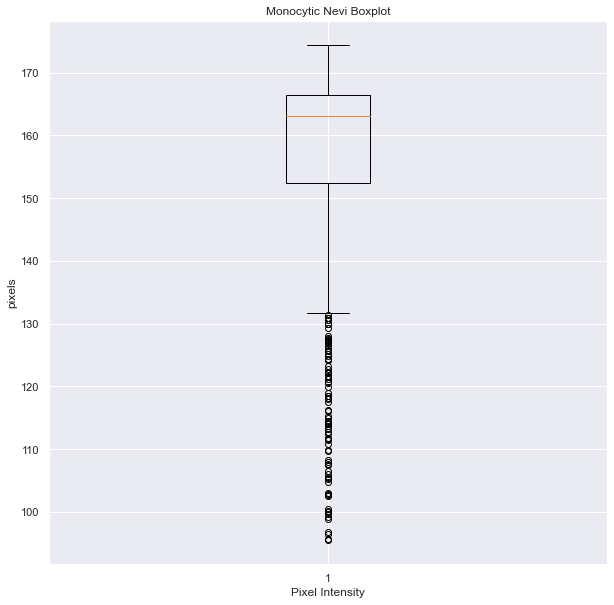

In [43]:
#Create a box plot
plt.boxplot(pixels_mn)
plt.title("Monocytic Nevi Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [44]:
# Computing 1st and 3rd Quartile
Q1_mn = pixels_mn.quantile(0.25)
Q3_mn = pixels_mn.quantile(0.75)

Q1_mn,Q3_mn


(152.4772557792692, 166.5193139448173)

### On Reduced Number of Rows - randomly sampled 1,100 images

In [45]:
#pick up the means for each pixel
av_mn_red=df_mn_red.mean(axis=0)
av_mn_red

pixel0000    154.427890
pixel0001    158.798359
pixel0002    162.214914
pixel0003    164.558688
pixel0004    166.907233
                ...    
pixel0780    160.433855
pixel0781    156.984191
pixel0782    153.074720
pixel0783    149.043997
label          4.000000
Length: 785, dtype: float64

In [46]:
#get rid of the label column
pixels_mn_red=av_mn_red[0:784]
pixels_mn_red

pixel0000    154.427890
pixel0001    158.798359
pixel0002    162.214914
pixel0003    164.558688
pixel0004    166.907233
                ...    
pixel0779    163.432215
pixel0780    160.433855
pixel0781    156.984191
pixel0782    153.074720
pixel0783    149.043997
Length: 784, dtype: float64

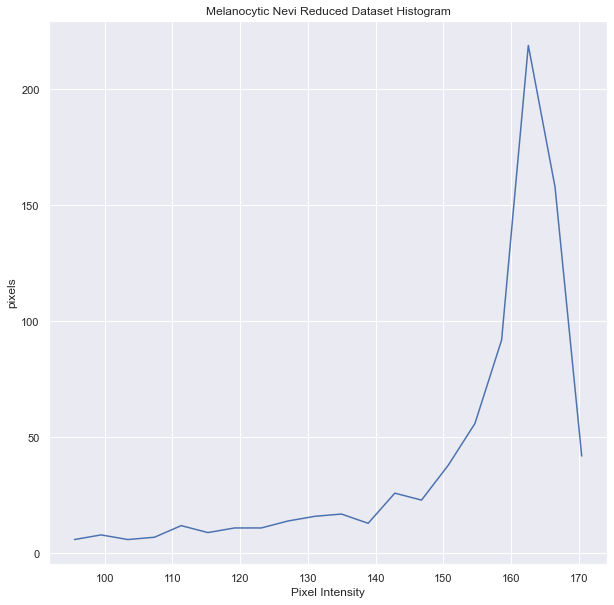

In [47]:
# Histogram of mean values of each pixel
histogram, bin_edges= np.histogram(pixels_mn_red,bins=20)
plt.plot(bin_edges[0:-1],histogram)
plt.title("Melanocytic Nevi Reduced Dataset Histogram")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [48]:
#Find kurtosis of the histogram
kurt_mn_red = kurtosis(pixels_mn_red, fisher=False)
kurt_mn_red

5.397026066934137

In [49]:
#Find Skewness of the histogram
skew_mn_red = skew(pixels_mn_red)
skew_mn_red

-1.7553433356402082

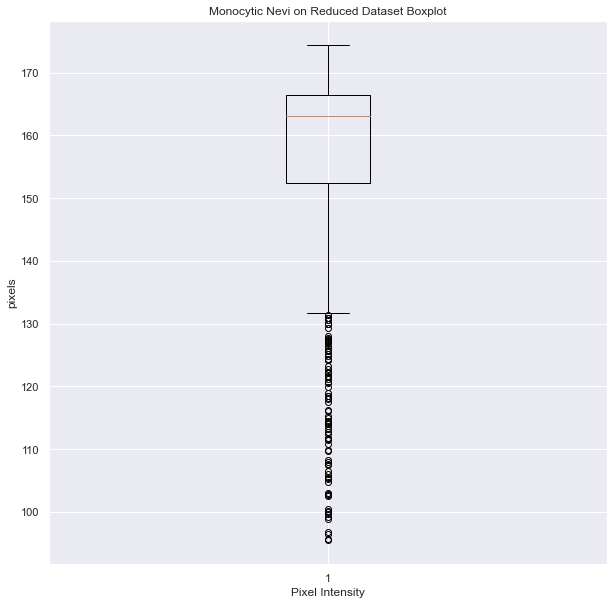

In [50]:
#Create a box plot
plt.boxplot(pixels_mn)
plt.title("Monocytic Nevi on Reduced Dataset Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [51]:
# Computing 1st and 3rd Quartile
Q1_mn_red = pixels_mn_red.quantile(0.25)
Q3_mn_red = pixels_mn_red.quantile(0.75)

Q1_mn_red,Q3_mn_red


(152.4772557792692, 166.5193139448173)

In [52]:
#Computing mean
mean_mn_red = statistics.mean(pixels_mn_red)
mean_mn_red

156.1532316729824

In [53]:
#Computing Standard Deviation
sd_mn_red = statistics.stdev(pixels_mn_red)
sd_mn_red

16.728576195882287

## 4.  Melanoma



In [54]:
# Get descriptive statistsics on melanoma dataset

df_melanoma.describe()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
count,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,...,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.0
mean,124.917341,134.283917,143.216532,149.942498,155.674753,160.734052,164.639712,167.229111,168.595687,169.725966,...,166.713387,165.237197,163.253369,160.430368,156.126685,149.589398,141.782570,132.428571,122.437556,6.0
std,61.334459,56.969908,51.043736,45.695724,40.033015,34.285608,30.644435,29.110040,28.467482,27.819101,...,27.768888,28.256873,29.385532,30.864796,34.597157,41.859878,49.161342,56.031294,61.502924,0.0
min,0.000000,0.000000,0.000000,0.000000,3.000000,10.000000,25.000000,29.000000,33.000000,26.000000,...,4.000000,4.000000,5.000000,3.000000,4.000000,0.000000,1.000000,0.000000,0.000000,6.0
25%,99.000000,115.000000,125.000000,134.000000,141.000000,144.000000,147.000000,148.000000,151.000000,153.000000,...,149.000000,148.000000,145.000000,142.000000,138.000000,132.000000,124.000000,112.000000,91.000000,6.0
50%,141.000000,148.000000,153.000000,156.000000,160.000000,163.000000,166.000000,168.000000,170.000000,170.000000,...,166.000000,165.000000,164.000000,162.000000,158.000000,154.000000,150.000000,145.000000,139.000000,6.0
75%,170.000000,174.000000,178.000000,179.000000,181.000000,182.000000,185.000000,186.000000,186.000000,186.000000,...,184.000000,183.000000,182.000000,181.000000,179.000000,177.000000,175.000000,172.000000,169.000000,6.0
max,245.000000,245.000000,246.000000,250.000000,247.000000,249.000000,247.000000,249.000000,254.000000,252.000000,...,254.000000,254.000000,252.000000,251.000000,253.000000,245.000000,243.000000,235.000000,234.000000,6.0


In [55]:
#pick up the means for each pixel
av_melanoma=df_melanoma.mean(axis=0)
av_melanoma

pixel0000    124.917341
pixel0001    134.283917
pixel0002    143.216532
pixel0003    149.942498
pixel0004    155.674753
                ...    
pixel0780    149.589398
pixel0781    141.782570
pixel0782    132.428571
pixel0783    122.437556
label          6.000000
Length: 785, dtype: float64

In [56]:
#get rid of the label column
pixels_melanoma=av_melanoma[0:784]
pixels_melanoma

pixel0000    124.917341
pixel0001    134.283917
pixel0002    143.216532
pixel0003    149.942498
pixel0004    155.674753
                ...    
pixel0779    156.126685
pixel0780    149.589398
pixel0781    141.782570
pixel0782    132.428571
pixel0783    122.437556
Length: 784, dtype: float64

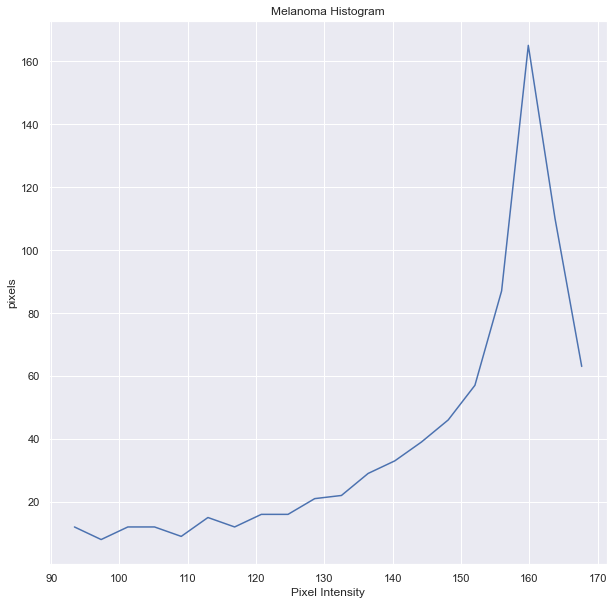

In [57]:
# Histogram of mean values of each pixel
histogram, bin_edges= np.histogram(pixels_melanoma,bins=20)
plt.plot(bin_edges[0:-1],histogram)
plt.title("Melanoma Histogram")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [58]:
#Find kurtosis of the histogram
kurt_mel = kurtosis(pixels_melanoma, fisher=False)
kurt_mel

3.869226216731156

In [59]:
#Find Skewness of the histogram
skew_mel = skew(pixels_melanoma)
skew_mel

-1.3087868472906514

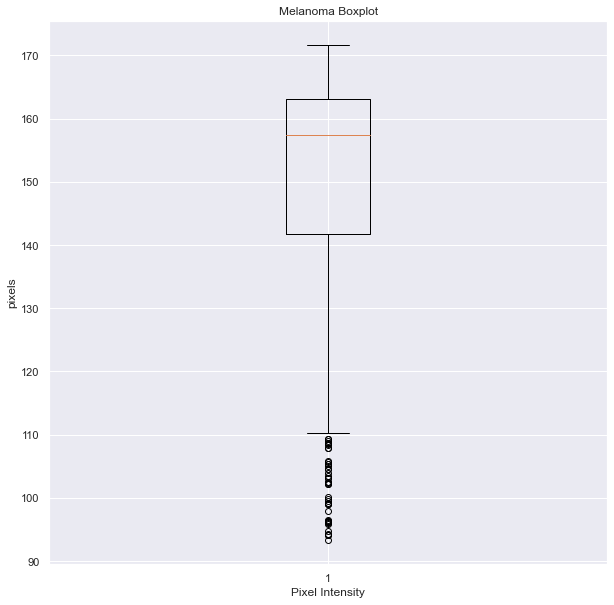

In [60]:
#Create a box plot
plt.boxplot(pixels_melanoma)
plt.title("Melanoma Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [61]:
# Computing 1st and 3rd Quartile
Q1_mel = pixels_melanoma.quantile(0.25)
Q3_mel = pixels_melanoma.quantile(0.75)

Q1_mel,Q3_mel


(141.76212938005392, 163.15790655884996)

In [62]:
#Computing mean
mean_mel = statistics.mean(pixels_melanoma)
mean_mel

150.20319232814418

In [63]:
#Computing SD

sd_mel = statistics.stdev(pixels_melanoma)
sd_mel

18.510582133315243

## SUMMARY OF FIRST ORDER STATISTICS
Lets now summarize all of this by putting boxplots for all 4 classes of diagnosis side by side so we can visualize means and create a table for all the statistsics we calculated:

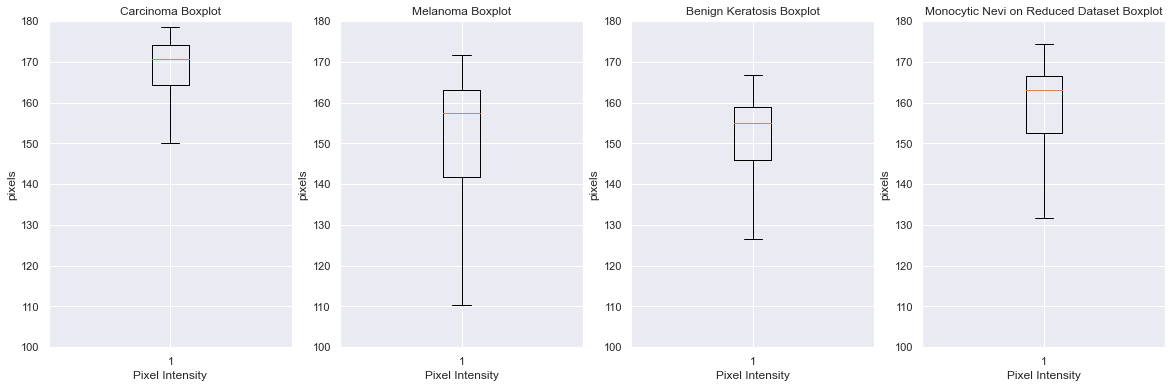

In [64]:
#Put all boxplots dide by side and on the same Y axis scale

plt.rcParams["figure.figsize"] = (20,6)


plt.subplot(1, 4, 1) # row , col 2 index 1
plt.boxplot(pixels_carc, showfliers=False)
plt.ylim([100, 180])
plt.title("Carcinoma Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")


plt.subplot(1, 4, 2) # index 2
plt.boxplot(pixels_melanoma, showfliers=False)
plt.ylim([100, 180])
plt.title("Melanoma Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")

plt.subplot(1, 4, 3) # index 3
plt.boxplot(pixels_bkl, showfliers=False)
plt.ylim([100, 180])
plt.title("Benign Keratosis Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")

plt.subplot(1, 4, 4) # index 4
plt.boxplot(pixels_mn_red, showfliers=False)
plt.ylim([100, 180])
plt.title("Monocytic Nevi on Reduced Dataset Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")

plt.show()

In [65]:
#create a summary of meand/SD/Q1/Q3/Kurtosis and Skewness for the 4 dataframes (diagnosis)
first_stats = pd.DataFrame({'parameters' : ['Mean', 'Standard Deviation','Q1', 'Q3','Kurtosis', 'Skewness'],
                            'Basal Cell Carcinoma' : [mean_carc, sd_carc, Q1_carc, Q3_carc, kurt_carc, skew_carc],
                            'Benign Keratosis': [mean_bkl, sd_bkl, Q1_bkl, Q3_bkl, kurt_bkl, skew_bkl],
                            'Melanocytic Nevi - Sample': [mean_mn_red, sd_mn_red,Q1_mn_red, Q3_mn_red, kurt_mn_red, skew_mn_red],
                            'Melanoma': [mean_mel, sd_mel, Q1_mel, Q3_mel, kurt_mel, skew_mel]})
print(first_stats)


           parameters  Basal Cell Carcinoma  Benign Keratosis  \
0                Mean            167.861041        151.448174   
1  Standard Deviation              8.622548         10.745750   
2                  Q1            164.331712        146.002957   
3                  Q3            174.027724        159.012056   
4            Kurtosis              4.396916          3.405378   
5            Skewness             -1.361853         -1.075407   

   Melanocytic Nevi - Sample    Melanoma  
0                 156.153232  150.203192  
1                  16.728576   18.510582  
2                 152.477256  141.762129  
3                 166.519314  163.157907  
4                   5.397026    3.869226  
5                  -1.755343   -1.308787  


From the boxplots and the table with first order statistics we can see that there are differences betwwen different diagnosis in terms of pixel intensity.  However, we wanted to confirm this using proper statistical test. We would have used t test to compare the means between different groups but the distribution may not be normal.  We chose Wilcoxon- Whitney test instead.  The null hypothesis is that the distributions in the two groups are the same.  We therefore take two by two groups and compare them.

In [66]:
# Comparisons using Wilcoxon–Mann–Whitney test

from scipy.stats import mannwhitneyu

# Melanoma vs Basal Cell Skin Carcinoma
melanoma_carc = mannwhitneyu(pixels_melanoma, pixels_carc)
melanoma_carc

MannwhitneyuResult(statistic=89119.0, pvalue=7.256272879551612e-131)

In [67]:
# Benign Keratosis vs Melanocytic Nevi
bkl_mn = mannwhitneyu(pixels_bkl, pixels_mn_red)
bkl_mn

MannwhitneyuResult(statistic=176825.0, pvalue=5.246233039424587e-48)

In [68]:
# Melanocytic Nevi Full Set vs Sample
mn_mn_red = mannwhitneyu(pixels_mn, pixels_mn_red)
mn_mn_red

MannwhitneyuResult(statistic=307328.0, pvalue=1.0)

In [69]:
#Melanoma Vs Benign Keratosis
melanoma_bkl = mannwhitneyu(pixels_melanoma, pixels_bkl)
melanoma_bkl

MannwhitneyuResult(statistic=347345.0, pvalue=8.05285259307314e-06)

We can see from the WMW test that p values are really small for all combinations tested which leads us to reject the null hypothesis and conclude that the difference in distribution is different for different diagnosis.  The difference is also significant beetween the two types of malignant conditions which is why we decided against lumping up togeether the two malignant and two benign conditions and only doing the classification between malignant vs benign.

## FEATURE SELECTION

At this point we are just experienting with feature selection for one image to understand the process

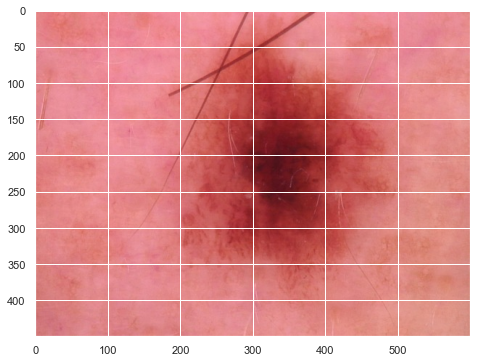

In [70]:
#import image
# test_image=plt.imread('ISIC_0024306.jpeg')
test_image=plt.imread('ISIC_0024306.jpeg')
test_plot=plt.imshow(test_image)
plt.show()

In [71]:
#resize the image and turn it into grayscale

image = cv2.resize(test_image,(100,100),interpolation = cv2.INTER_AREA)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img   

array([[142, 144, 140, ..., 152, 144, 145],
       [144, 142, 139, ..., 152, 148, 148],
       [144, 142, 138, ..., 154, 155, 150],
       ...,
       [132, 132, 131, ..., 153, 149, 146],
       [131, 132, 132, ..., 151, 148, 147],
       [130, 129, 132, ..., 151, 149, 146]], dtype=uint8)

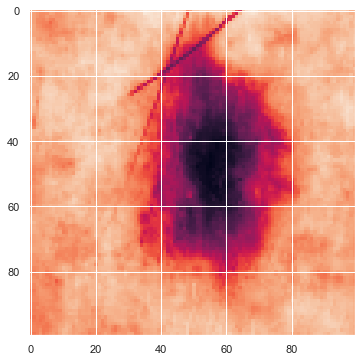

In [72]:
#take a look at the grayscale image
gray_plot=plt.imshow(img)
plt.show()

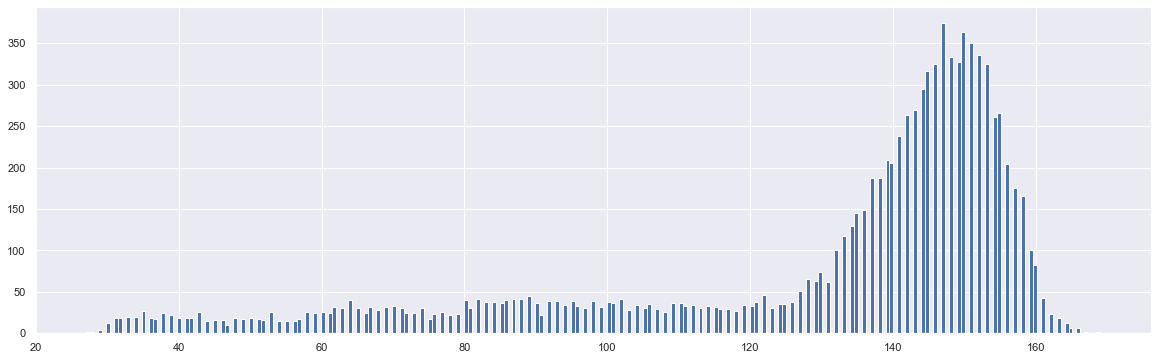

In [73]:
#plot a histogram of the pixel intensity 
plt.hist(img.ravel(), bins=255)
plt.show()

### Experiment with different filtering techniques to separate the background (skin) and the area of interest (AOI -lesion)

Several different techniques were tried including sift, adaptive mean thresholding, Denoising, Lapliacian gausian filter and thresholding.  The best results were achieved with thresholding as presented below on the same image used above:


In [74]:
#import libraries
import skimage.io
import skimage.color
import skimage.filters

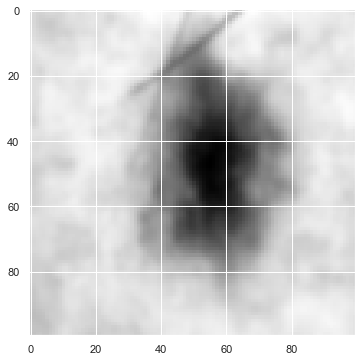

In [75]:
#Convert the image grayscale
gray_img=skimage.color.rgb2gray(image)
#blur the image to denoise
blurred_image=skimage.filters.gaussian(gray_img,sigma=1.0)
#Plot preprocessed image
fig,ax=plt.subplots()
plt.imshow(blurred_image,cmap='gray')
plt.show()

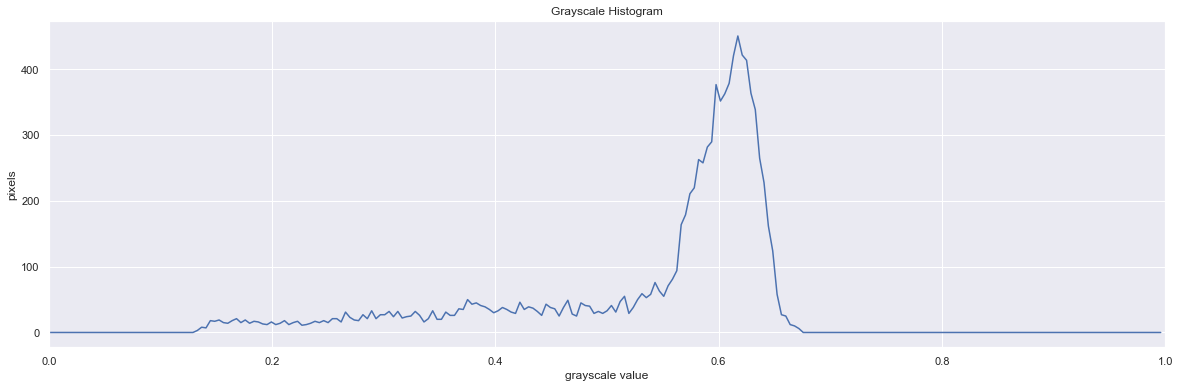

In [76]:
#Create a histogram of the blurred grascale image 
histogram, bin_edges= np.histogram(blurred_image,bins=256,range=(0.0,1.0))
plt.plot(bin_edges[0:-1],histogram)
plt.title("Grayscale Histogram")
plt.xlabel('grayscale value')
plt.ylabel("pixels")
plt.xlim(0,1.0)
plt.show()

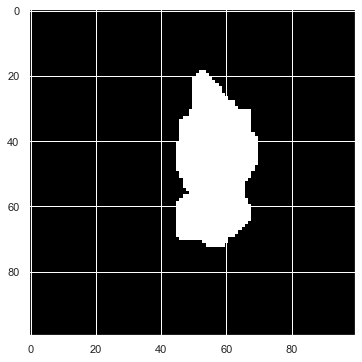

In [77]:
#Create a mask based on the threshold 
t=0.34
binary_mask=blurred_image<t
fig,ax = plt.subplots()
plt.imshow(binary_mask,cmap='gray')
plt.show()

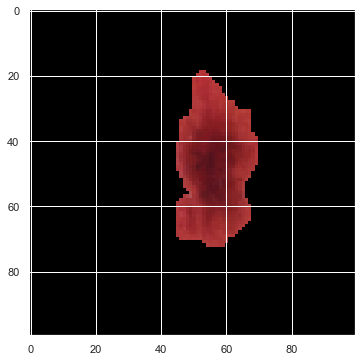

In [78]:
#use the binary mask to select the interesting part of the image 
selection=np.zeros_like(image)
selection[binary_mask]=image[binary_mask]
fig,ax=plt.subplots()
plt.imshow(selection)
plt.show()

## GRAY LEVEL COOCURRANCE MATRIX

In [79]:
# create patches 

PATCH_SIZE = 20

# select some patches from skin areas of the image - on the image above pick up some coordinates corresponding to the black area
skin_locations = [(20,85), (80,50), (15,15), (15,90)]
skin_patches = []
for loc in skin_locations:
    skin_patches.append(img[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from AOI of the image - red area
lesion_locations = [(50,50), (60,60), (60,40), (50,40)]
lesion_patches = []
for loc in lesion_locations:
    lesion_patches.append(img[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
diss_sim = []
corr = []
homogen = []
energy = []
contrast = []
for patch in (skin_patches + lesion_patches):
    glcm = greycomatrix(patch, distances=[2], angles=[0], levels=256,
                        symmetric=True, normed=True)
    diss_sim.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    corr.append(greycoprops(glcm, 'correlation')[0, 0])
    homogen.append(greycoprops(glcm, 'homogeneity')[0, 0])
    energy.append(greycoprops(glcm, 'energy')[0, 0])
    contrast.append(greycoprops(glcm, 'contrast')[0, 0])


    

We will add these GLCM properties that we just calculated to a dataframe along with metadata.  For now we will just visualize how the sparation based on the texture works:

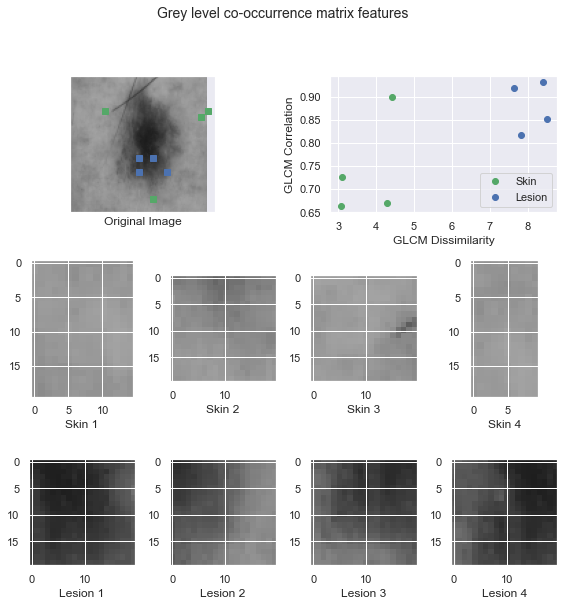

In [80]:
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(img, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in skin_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in lesion_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(diss_sim[:len(skin_patches)], corr[:len(skin_patches)], 'go',
        label='Skin')
ax.plot(diss_sim[len(skin_patches):], corr[len(skin_patches):], 'bo',
        label='Lesion')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(skin_patches):
    ax = fig.add_subplot(3, len(skin_patches), len(skin_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Skin %d' % (i + 1))

for i, patch in enumerate(lesion_patches):
    ax = fig.add_subplot(3, len(lesion_patches), len(lesion_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Lesion %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

Based on the correlation vs dissimilarity plot we can see that we already have pretty good separation between skin and the lesion.  To improve, we can tweak the size of the patch, the angle and the distance between pixels compared.  This will be done in a loop when the whole dataset is merged.  Ultimately, the features selected through this process will  be used to run K-means.

## MERGE METADATA AND IMAGES/FEATURES FOR EACH DIAGNOSIS

Next we need to append images associated with each diagnosis to their respective meta data dataframe.  For that we created a function which reads the image, vectorizes RGB and Grayscale pixels and at the same time calculates the GLCM features (more about this later!).  RGB, Grayscale as well as dissimilarity, correlation, homogeneity, energy and contrast (features extracted by GLCM) are added as new columns to the dataframe in a form of arrays.

In [81]:
dfOutput.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,RGB,GrayScale
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,"[191, 147, 188, 189, 148, 186, 191, 150, 187, ...","[164, 164, 166, 167, 168, 171, 170, 171, 171, ..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,"[23, 15, 25, 22, 14, 25, 22, 14, 25, 22, 14, 2...","[19, 18, 18, 18, 18, 19, 19, 17, 16, 18, 18, 1..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,"[140, 128, 186, 136, 128, 188, 133, 126, 183, ...","[147, 147, 144, 147, 149, 151, 152, 155, 157, ..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,"[16, 9, 24, 15, 11, 22, 15, 11, 23, 16, 11, 26...","[14, 15, 15, 16, 15, 16, 15, 16, 16, 16, 18, 1..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,"[102, 80, 122, 104, 82, 124, 106, 83, 127, 109...","[95, 97, 99, 102, 105, 107, 109, 110, 113, 115..."


In [149]:
dfOutput.to_csv("dfOutput.csv")

In [82]:
# create a function to call the GRAY LEVEL COOCURRANCE MATRIX method
def glcm_cal(skin_input_list, dx_input_list, distance_input=[2], angle_input=[0]):
    # Input
    # skin_input_list -> list of skin patch input
    # dx_input_list -> list of specific dx patch input
    # distance_input -> distance parameter in glcm method called
    # angle_input -> angle parameter in glcm method called
    # Output
    # diss_sim -> list of diss_sim
    # corr -> list of corr
    # homogen -> list of homogen
    # energy -> list of energy
    # contrast -> list of contrast
    # Initialize the return value
    diss_sim = []
    corr = []
    homogen = []
    energy = []
    contrast = []
        
    for patch in (skin_input_list + dx_input_list):
        # print('start for in glcm_cal')
        glcm = greycomatrix(patch, distances=distance_input, angles=angle_input, levels=256,
                            symmetric=True, normed=True)
        diss_sim.append(greycoprops(glcm, 'dissimilarity')[0, 0])
        corr.append(greycoprops(glcm, 'correlation')[0, 0])
        homogen.append(greycoprops(glcm, 'homogeneity')[0, 0])
        energy.append(greycoprops(glcm, 'energy')[0, 0])
        contrast.append(greycoprops(glcm, 'contrast')[0, 0])
        # print('end for in glcm_cal')
        
    return diss_sim, corr, homogen, energy, contrast

In [83]:
dfOutput.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,RGB,GrayScale
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,"[191, 147, 188, 189, 148, 186, 191, 150, 187, ...","[164, 164, 166, 167, 168, 171, 170, 171, 171, ..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,"[23, 15, 25, 22, 14, 25, 22, 14, 25, 22, 14, 2...","[19, 18, 18, 18, 18, 19, 19, 17, 16, 18, 18, 1..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,"[140, 128, 186, 136, 128, 188, 133, 126, 183, ...","[147, 147, 144, 147, 149, 151, 152, 155, 157, ..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,"[16, 9, 24, 15, 11, 22, 15, 11, 23, 16, 11, 26...","[14, 15, 15, 16, 15, 16, 15, 16, 16, 16, 18, 1..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,"[102, 80, 122, 104, 82, 124, 106, 83, 127, 109...","[95, 97, 99, 102, 105, 107, 109, 110, 113, 115..."


In [84]:
#split dataset into 4 different dataframes based on the diagnosis
df_carcinoma1=dfOutput[dfOutput['dx']=="bcc"]
df_bkl1=dfOutput[dfOutput['dx']=="bkl"]
df_mn1=dfOutput[dfOutput['dx']=="nv"]
df_melanoma1=dfOutput[dfOutput['dx']=="mel"]

Please note that the above is not a duplication of code.  Previuosly we split up the 28 x 28 L pixel file to look at the preliminary ststistics.  Here we are splitting the merged dataframe that contains metadata with the RGB/Grayscale and GLCM features so that images of the dx dropped are not loaded (to conserve resources and speed the code).

In [85]:
#sample melanocytic nevi and obtain 1100 items
df_mn_red1 = df_mn1.sample(n=1100,random_state=142)
df_mn_red1.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,RGB,GrayScale
4233,HAM_0004858,ISIC_0032239,nv,follow_up,50.0,female,trunk,"[150, 152, 236, 151, 152, 233, 154, 153, 233, ...","[177, 176, 177, 175, 176, 175, 172, 174, 177, ..."
8248,HAM_0004239,ISIC_0029450,nv,histo,75.0,female,lower extremity,"[177, 169, 222, 181, 173, 226, 179, 173, 226, ...","[186, 190, 190, 193, 195, 198, 199, 198, 197, ..."
4291,HAM_0000385,ISIC_0024611,nv,follow_up,50.0,female,back,"[173, 164, 244, 175, 164, 244, 173, 164, 244, ...","[189, 189, 189, 188, 190, 192, 191, 188, 191, ..."
7187,HAM_0007127,ISIC_0032362,nv,histo,35.0,female,chest,"[161, 158, 180, 162, 159, 181, 163, 161, 181, ...","[165, 166, 167, 168, 167, 167, 167, 168, 167, ..."
8838,HAM_0006420,ISIC_0029905,nv,histo,50.0,female,upper extremity,"[165, 145, 187, 166, 146, 189, 165, 145, 188, ...","[160, 161, 160, 160, 159, 159, 159, 159, 160, ..."


In [86]:
#merge 4 different diagnois files into one dataframe
dfs = [df_carcinoma1, df_bkl1,df_mn_red1,df_melanoma1]

new_df = pd.concat(dfs)
new_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,RGB,GrayScale
2462,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,"[23, 17, 22, 18, 13, 15, 21, 15, 20, 22, 17, 1...","[19, 14, 17, 18, 17, 17, 19, 21, 18, 17, 17, 1..."
2463,HAM_0003220,ISIC_0034093,bcc,histo,80.0,female,face,"[194, 172, 196, 198, 175, 190, 201, 174, 194, ...","[182, 182, 183, 185, 182, 183, 184, 182, 185, ..."
2464,HAM_0007141,ISIC_0029230,bcc,histo,50.0,male,trunk,"[201, 178, 186, 202, 179, 187, 202, 180, 185, ...","[183, 184, 184, 183, 183, 183, 182, 182, 183, ..."
2465,HAM_0007141,ISIC_0031513,bcc,histo,50.0,male,trunk,"[22, 12, 18, 20, 12, 19, 22, 12, 18, 23, 12, 2...","[15, 15, 15, 16, 16, 17, 20, 21, 24, 28, 33, 3..."
2466,HAM_0007009,ISIC_0032384,bcc,histo,50.0,male,back,"[211, 198, 222, 210, 197, 221, 209, 196, 220, ...","[207, 206, 205, 206, 205, 206, 207, 205, 206, ..."


Here we attempted to run Kmeans with GraysScale values in a form of an array just to test if its the correct data type.  We were unable to run it.  As a result for our feature selection (GLCM) loop below we added the resulting values (features) into separate columns of the dataframe. <br>

# WARNING - THE CELL BELOW TAKES ABOUT 20 MINS TO RUN - USE AZURE OR GOOGLE COLAB BUT YOU WILL NEED TO IMPORT ALL THE IMAGES FIRST; ALTERNATIVELY WE OUTPUTTED THE DATAFRAME THAT THIS CODE GENERATES THAT YOU CAN IMPORT BELOW AND CONTINUE RUNNING KMEANS TRIALS

In [87]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("start Time =", current_time)

# list for glcm function output
diss_sim_out = []
corr_out = []
homogen_out = []
energy_out = []
contrast_out = []

sum_diss_sim_out = []
sum_corr_out = []
sum_homogen_out = []
sum_energy_out = []
sum_contrast_out = []

PATCH_SIZE = 20

# select some patches from skin areas of the image - on the image above pick up some coordinates corresponding to the black area
skin_locations = [(20,85), (80,50), (15,15), (15,90)]

# select some patches from AOI of the image - red area
lesion_locations = [(50,50), (60,60), (60,40), (50,40)]

for ind in new_df.index:
    imgLoad = new_df.at[ind,'GrayScale'].reshape(450, 600)
    skin_patches = []
    for loc in skin_locations:
        # skin_patches.append(gray2[loc[0]:loc[0] + PATCH_SIZE, loc[1]:loc[1] + PATCH_SIZE])
        # print('create skin_locations' + str(ind) )
        skin_patches.append(imgLoad[loc[0]:loc[0] + PATCH_SIZE, loc[1]:loc[1] + PATCH_SIZE])
    
    lesion_patches = []
    for loc in lesion_locations:
        # lesion_patches.append(gray2[loc[0]:loc[0] + PATCH_SIZE, loc[1]:loc[1] + PATCH_SIZE])    
        # print('create lesion_locations' + str(ind) )
        lesion_patches.append(imgLoad[loc[0]:loc[0] + PATCH_SIZE, loc[1]:loc[1] + PATCH_SIZE])
    
    # print('call glcm_cal ' + str(ind) )
    diss_sim_out, corr_out, homogen_out, energy_out, contrast_out = glcm_cal(skin_patches, lesion_patches)
    # print('end glcm_cal ' + str(ind) )
    # print('diss_sim_out')
    # print(diss_sim_out)
    # print('corr_out')
    # print(corr_out)
    # dfOutput.at[ind, 'diss_sim'] = diss_sim_out
    # dfOutput.at[ind, 'corr'] = corr_out
    # dfOutput.at[ind, 'homogen'] = homogen_out
    # dfOutput.at[ind, 'energy'] = energy_out
    # dfOutput.at[ind, 'contrast'] = contrast_out
    sum_diss_sim_out.append(diss_sim_out)
    sum_corr_out.append(corr_out)
    sum_homogen_out.append(homogen_out)
    sum_energy_out.append(energy_out)
    sum_contrast_out.append(contrast_out)

new_df_diss_sim = pd.DataFrame(sum_diss_sim_out, columns=['diss_sim_0', 'diss_sim_1', 'diss_sim_2', 'diss_sim_3', 'diss_sim_4', 'diss_sim_5', 'diss_sim_6', 'diss_sim_7'])
new_df_corr = pd.DataFrame(sum_corr_out, columns=['corr_0', 'corr_1', 'corr_2', 'corr_3', 'corr_4', 'corr_5', 'corr_6', 'corr_7'])
new_df_homogen = pd.DataFrame(sum_homogen_out, columns=['homogen_0', 'homogen_1', 'homogen_2', 'homogen_3', 'homogen_4', 'homogen_5', 'homogen_6', 'homogen_7'])
new_df_energy = pd.DataFrame(sum_energy_out, columns=['energy_0', 'energy_1', 'energy_2', 'energy_3', 'energy_4', 'energy_5', 'energy_6', 'energy_7'])
new_df_contrast = pd.DataFrame(sum_contrast_out, columns=['contrast_0', 'contrast_1', 'contrast_2', 'contrast_3', 'contrast_4', 'contrast_5', 'contrast_6', 'contrast_7'])

# split the resulting list into separate columns
# work with warning message
new_df['diss_sim_0'] = new_df_diss_sim['diss_sim_0'].to_numpy()
new_df['diss_sim_1'] = new_df_diss_sim['diss_sim_1'].to_numpy()
new_df['diss_sim_2'] = new_df_diss_sim['diss_sim_2'].to_numpy()
new_df['diss_sim_3'] = new_df_diss_sim['diss_sim_3'].to_numpy()
new_df['diss_sim_4'] = new_df_diss_sim['diss_sim_4'].to_numpy()
new_df['diss_sim_5'] = new_df_diss_sim['diss_sim_5'].to_numpy()
new_df['diss_sim_6'] = new_df_diss_sim['diss_sim_6'].to_numpy()
new_df['diss_sim_7'] = new_df_diss_sim['diss_sim_7'].to_numpy()

new_df['corr_0'] = new_df_corr['corr_0'].to_numpy()
new_df['corr_1'] = new_df_corr['corr_1'].to_numpy()
new_df['corr_2'] = new_df_corr['corr_2'].to_numpy()
new_df['corr_3'] = new_df_corr['corr_3'].to_numpy()
new_df['corr_4'] = new_df_corr['corr_4'].to_numpy()
new_df['corr_5'] = new_df_corr['corr_5'].to_numpy()
new_df['corr_6'] = new_df_corr['corr_6'].to_numpy()
new_df['corr_7'] = new_df_corr['corr_7'].to_numpy()

new_df['homogen_0'] = new_df_homogen['homogen_0'].to_numpy()
new_df['homogen_1'] = new_df_homogen['homogen_1'].to_numpy()
new_df['homogen_2'] = new_df_homogen['homogen_2'].to_numpy()
new_df['homogen_3'] = new_df_homogen['homogen_3'].to_numpy()
new_df['homogen_4'] = new_df_homogen['homogen_4'].to_numpy()
new_df['homogen_5'] = new_df_homogen['homogen_5'].to_numpy()
new_df['homogen_6'] = new_df_homogen['homogen_6'].to_numpy()
new_df['homogen_7'] = new_df_homogen['homogen_7'].to_numpy()

new_df['energy_0'] = new_df_energy['energy_0'].to_numpy()
new_df['energy_1'] = new_df_energy['energy_1'].to_numpy()
new_df['energy_2'] = new_df_energy['energy_2'].to_numpy()
new_df['energy_3'] = new_df_energy['energy_3'].to_numpy()
new_df['energy_4'] = new_df_energy['energy_4'].to_numpy()
new_df['energy_5'] = new_df_energy['energy_5'].to_numpy()
new_df['energy_6'] = new_df_energy['energy_6'].to_numpy()
new_df['energy_7'] = new_df_energy['energy_7'].to_numpy()

new_df['contrast_0'] = new_df_contrast['contrast_0'].to_numpy()
new_df['contrast_1'] = new_df_contrast['contrast_1'].to_numpy()
new_df['contrast_2'] = new_df_contrast['contrast_2'].to_numpy()
new_df['contrast_3'] = new_df_contrast['contrast_3'].to_numpy()
new_df['contrast_4'] = new_df_contrast['contrast_4'].to_numpy()
new_df['contrast_5'] = new_df_contrast['contrast_5'].to_numpy()
new_df['contrast_6'] = new_df_contrast['contrast_6'].to_numpy()
new_df['contrast_7'] = new_df_contrast['contrast_7'].to_numpy()    

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("end Time =", current_time)

start Time = 20:40:15
end Time = 20:51:03


In [88]:
#export dataframe created in the cell above to csv 
new_df.to_csv("new_df.csv")

In [89]:
#import output file from the CNN feature extraction
#new_df=pd.read_csv('new_df.csv')

In [90]:
#look at first 5 rows of the new dataframe containing each feature as separate column
new_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,RGB,GrayScale,diss_sim_0,...,energy_6,energy_7,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7
2462,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,"[23, 17, 22, 18, 13, 15, 21, 15, 20, 22, 17, 1...","[19, 14, 17, 18, 17, 17, 19, 21, 18, 17, 17, 1...",1.858333,...,0.115135,0.115537,5.963889,6.483333,160.152778,6.738889,9.172222,9.300000,6.916667,6.941667
2463,HAM_0003220,ISIC_0034093,bcc,histo,80.0,female,face,"[194, 172, 196, 198, 175, 190, 201, 174, 194, ...","[182, 182, 183, 185, 182, 183, 184, 182, 185, ...",1.050000,...,0.145853,0.174934,1.916667,3.477778,2.269444,1.747222,3.030556,3.852778,2.705556,2.586111
2464,HAM_0007141,ISIC_0029230,bcc,histo,50.0,male,trunk,"[201, 178, 186, 202, 179, 187, 202, 180, 185, ...","[183, 184, 184, 183, 183, 183, 182, 182, 183, ...",1.116667,...,0.192560,0.211312,2.211111,2.000000,1.877778,2.172222,2.075000,3.108333,2.508333,2.463889
2465,HAM_0007141,ISIC_0031513,bcc,histo,50.0,male,trunk,"[22, 12, 18, 20, 12, 19, 22, 12, 18, 23, 12, 2...","[15, 15, 15, 16, 16, 17, 20, 21, 24, 28, 33, 3...",1.322222,...,0.110990,0.124614,2.955556,3.822222,17.461111,2.802778,2.791667,2.325000,4.352778,2.619444
2466,HAM_0007009,ISIC_0032384,bcc,histo,50.0,male,back,"[211, 198, 222, 210, 197, 221, 209, 196, 220, ...","[207, 206, 205, 206, 205, 206, 207, 205, 206, ...",1.536111,...,0.137367,0.117884,3.941667,4.572222,4.022222,4.747222,53.052778,22.761111,30.475000,41.169444


In [91]:
#look at frequency count for each dx 
new_df.groupby("dx").count()

,lesion_id,image_id,dx_type,age,sex,localization,RGB,GrayScale,diss_sim_0,diss_sim_1,...,energy_6,energy_7,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7
dx,,,,,,,,,,,,,,,,,,,,,
bcc,514,514,514,514,514,514,514,514,514,514,...,514,514,514,514,514,514,514,514,514,514
bkl,1099,1099,1099,1089,1099,1099,1099,1099,1099,1099,...,1099,1099,1099,1099,1099,1099,1099,1099,1099,1099
mel,1113,1113,1113,1111,1113,1113,1113,1113,1113,1113,...,1113,1113,1113,1113,1113,1113,1113,1113,1113,1113
nv,1100,1100,1100,1092,1100,1100,1100,1100,1100,1100,...,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100


<AxesSubplot:xlabel='count', ylabel='dx'>

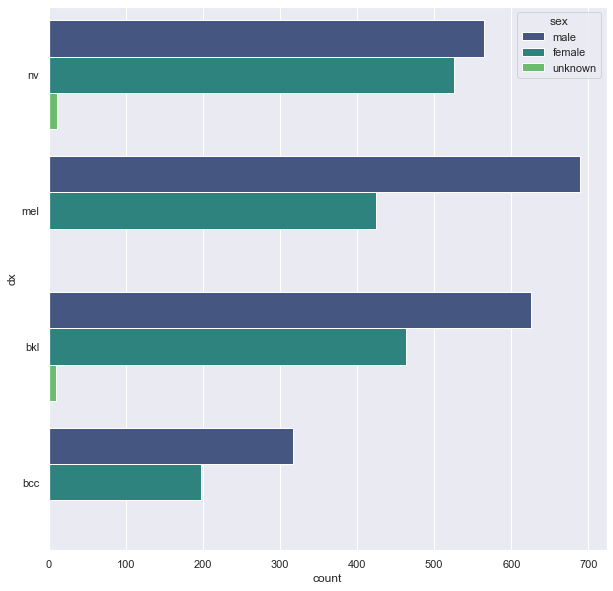

In [92]:
#replot age and gender distribution by dx for the reduced dataset

sns.set(rc={'figure.figsize':(10,10)})

sns.countplot(y='dx',order=['nv','mel','bkl','bcc'], data=new_df, palette='viridis', hue='sex')

C:\Users\Tanja\anaconda3\envs\CPSC_4830\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Tanja\anaconda3\envs\CPSC_4830\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Tanja\anaconda3\envs\CPSC_4830\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

<Figure size 720x720 with 0 Axes>

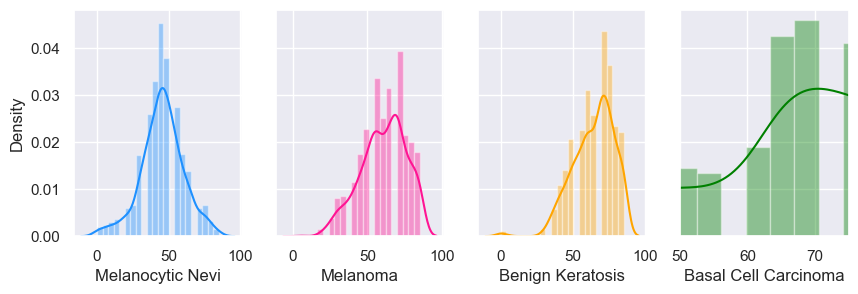

In [93]:
#age distribution for the 4 most common conditions on the reduced dataset

# Import data
df = new_df
x1 = df.loc[df.dx=='nv', ['age']]
x2 = df.loc[df.dx=='mel', ['age']]
x3 = df.loc[df.dx=='bkl',['age']]
x4 = df.loc[df.dx=='bcc',['age']]


# plot
plt.suptitle('Age Distribution for Different Types of Skin Lesions');
fig, axes = plt.subplots(1,4 , figsize=(10, 3), sharey=True, dpi=100)
sns.distplot(x1 , color="dodgerblue", ax=axes[0], axlabel='Melanocytic Nevi')
sns.distplot(x2 , color="deeppink", ax=axes[1], axlabel='Melanoma')
sns.distplot(x3 , color="orange", ax=axes[2], axlabel='Benign Keratosis')
sns.distplot(x4 , color="green", ax=axes[3], axlabel='Basal Cell Carcinoma')
plt.xlim(50,75);

In [94]:
#drop columns that are not relevant to our model and drop the ground truth
new_df2 = new_df.drop(["lesion_id", "image_id", "dx","RGB","GrayScale", "dx_type"], axis=1)

In [95]:
#recode categorical to factor
new_df2["sex"] = new_df2["sex"].astype('category')
new_df2["localization"]=new_df2["localization"].astype('category')
new_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3826 entries, 2462 to 10014
Data columns (total 43 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   age           3806 non-null   float64 
 1   sex           3826 non-null   category
 2   localization  3826 non-null   category
 3   diss_sim_0    3826 non-null   float64 
 4   diss_sim_1    3826 non-null   float64 
 5   diss_sim_2    3826 non-null   float64 
 6   diss_sim_3    3826 non-null   float64 
 7   diss_sim_4    3826 non-null   float64 
 8   diss_sim_5    3826 non-null   float64 
 9   diss_sim_6    3826 non-null   float64 
 10  diss_sim_7    3826 non-null   float64 
 11  corr_0        3826 non-null   float64 
 12  corr_1        3826 non-null   float64 
 13  corr_2        3826 non-null   float64 
 14  corr_3        3826 non-null   float64 
 15  corr_4        3826 non-null   float64 
 16  corr_5        3826 non-null   float64 
 17  corr_6        3826 non-null   float64 
 18  corr

In [96]:
new_df2["sex_cat"] = new_df2["sex"].cat.codes
new_df2["loc_cat"] = new_df2["localization"].cat.codes
new_df2.head()

,age,sex,localization,diss_sim_0,diss_sim_1,diss_sim_2,diss_sim_3,diss_sim_4,diss_sim_5,diss_sim_6,...,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7,sex_cat,loc_cat
2462,50.0,male,back,1.858333,1.905556,11.375000,1.955556,2.188889,2.200000,1.966667,...,5.963889,6.483333,160.152778,6.738889,9.172222,9.300000,6.916667,6.941667,1,2
2463,80.0,female,face,1.050000,1.477778,1.130556,1.002778,1.297222,1.536111,1.250000,...,1.916667,3.477778,2.269444,1.747222,3.030556,3.852778,2.705556,2.586111,0,5
2464,50.0,male,trunk,1.116667,1.038889,1.044444,1.094444,1.080556,1.369444,1.191667,...,2.211111,2.000000,1.877778,2.172222,2.075000,3.108333,2.508333,2.463889,1,12
2465,50.0,male,trunk,1.322222,1.344444,3.888889,1.291667,1.269444,1.141667,1.536111,...,2.955556,3.822222,17.461111,2.802778,2.791667,2.325000,4.352778,2.619444,1,12
2466,50.0,male,back,1.536111,1.633333,1.583333,1.669444,3.841667,2.855556,2.630556,...,3.941667,4.572222,4.022222,4.747222,53.052778,22.761111,30.475000,41.169444,1,2


In [97]:
#drop categorical columns keep equivalent factor columns
new_df3 = new_df2.drop(["sex","age", "localization"], axis=1)
new_df3.head()

,diss_sim_0,diss_sim_1,diss_sim_2,diss_sim_3,diss_sim_4,diss_sim_5,diss_sim_6,diss_sim_7,corr_0,corr_1,...,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7,sex_cat,loc_cat
2462,1.858333,1.905556,11.375000,1.955556,2.188889,2.200000,1.966667,2.019444,0.453716,0.640727,...,5.963889,6.483333,160.152778,6.738889,9.172222,9.300000,6.916667,6.941667,1,2
2463,1.050000,1.477778,1.130556,1.002778,1.297222,1.536111,1.250000,1.241667,0.704285,0.843067,...,1.916667,3.477778,2.269444,1.747222,3.030556,3.852778,2.705556,2.586111,0,5
2464,1.116667,1.038889,1.044444,1.094444,1.080556,1.369444,1.191667,1.213889,0.612831,0.644780,...,2.211111,2.000000,1.877778,2.172222,2.075000,3.108333,2.508333,2.463889,1,12
2465,1.322222,1.344444,3.888889,1.291667,1.269444,1.141667,1.536111,1.230556,0.748225,0.862436,...,2.955556,3.822222,17.461111,2.802778,2.791667,2.325000,4.352778,2.619444,1,12
2466,1.536111,1.633333,1.583333,1.669444,3.841667,2.855556,2.630556,3.458333,0.626235,0.643702,...,3.941667,4.572222,4.022222,4.747222,53.052778,22.761111,30.475000,41.169444,1,2


In [98]:
#look at the datatypes of our final dataframe
new_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3826 entries, 2462 to 10014
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   diss_sim_0  3826 non-null   float64
 1   diss_sim_1  3826 non-null   float64
 2   diss_sim_2  3826 non-null   float64
 3   diss_sim_3  3826 non-null   float64
 4   diss_sim_4  3826 non-null   float64
 5   diss_sim_5  3826 non-null   float64
 6   diss_sim_6  3826 non-null   float64
 7   diss_sim_7  3826 non-null   float64
 8   corr_0      3826 non-null   float64
 9   corr_1      3826 non-null   float64
 10  corr_2      3826 non-null   float64
 11  corr_3      3826 non-null   float64
 12  corr_4      3826 non-null   float64
 13  corr_5      3826 non-null   float64
 14  corr_6      3826 non-null   float64
 15  corr_7      3826 non-null   float64
 16  homogen_0   3826 non-null   float64
 17  homogen_1   3826 non-null   float64
 18  homogen_2   3826 non-null   float64
 19  homogen_3   3826 non-nu

In [148]:
new_df3.to_csv("new_df3.csv")

We also need to standardize our data because the values are of different order of magnitude

In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

Sc = StandardScaler()
X = Sc.fit_transform(new_df3)
X

array([[-0.45198248, -0.44600617,  4.1408263 , ..., -0.17904964,
         0.82393389, -1.01440623],
       [-0.75894473, -0.61902489, -0.78550639, ..., -0.21212036,
        -1.16118643, -0.36401216],
       [-0.73362825, -0.79653761, -0.82691537, ..., -0.21304836,
         0.82393389,  1.15357402],
       ...,
       [-0.27687687, -0.24714699, -0.44087683, ..., -0.13817525,
         0.82393389,  1.58717007],
       [-0.24734099, -0.36174381, -0.12697006, ..., -0.15511134,
         0.82393389,  1.58717007],
       [ 0.59337691,  0.42807542,  0.71857458, ..., -0.10687618,
        -1.16118643, -1.01440623]])

Now we are finally ready to run our model!

# K-MEANS

We use default settings of the Kmeans function for all 3 methods below as a baseline.  The initiation by default is kmeans++ the number of iterations is 10 and the maximum iterations is 300 based on the sklearn.cluster package documentaion in Python which can be accessed here: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
For model evaluation, we use the Adjusted Rand IndexThe Rand Index which computes similarity between two clusterings (the cluster assignment and ground truth in our case) by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.  The score is then adjusted for "chance".  The possible values are from -1 to 1 with a 0 being random placement.
We did not run the timer on the execution of the kmeans in any of the cases below as it took only few seconds given the small number of iterations.  We will add it in the future runs and possibly dump the dataframe in csv and import in Azure if we need it.

# Features extracted manually using GLCM

In [100]:
#import the required library
from sklearn.cluster import KMeans

In [144]:
#run k-means on the prepared dataframe

kmeans = KMeans(n_clusters=4).fit(X)
kmeans.labels_

array([1, 1, 1, ..., 2, 2, 0])

In [145]:
#create a new column in the original dataframe to add cluster number
new_df["cluster_km"] = kmeans.labels_
new_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,RGB,GrayScale,diss_sim_0,...,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7,cluster_km,cluster_km_random
2462,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,"[23, 17, 22, 18, 13, 15, 21, 15, 20, 22, 17, 1...","[19, 14, 17, 18, 17, 17, 19, 21, 18, 17, 17, 1...",1.858333,...,5.963889,6.483333,160.152778,6.738889,9.172222,9.300000,6.916667,6.941667,1,1
2463,HAM_0003220,ISIC_0034093,bcc,histo,80.0,female,face,"[194, 172, 196, 198, 175, 190, 201, 174, 194, ...","[182, 182, 183, 185, 182, 183, 184, 182, 185, ...",1.050000,...,1.916667,3.477778,2.269444,1.747222,3.030556,3.852778,2.705556,2.586111,1,1
2464,HAM_0007141,ISIC_0029230,bcc,histo,50.0,male,trunk,"[201, 178, 186, 202, 179, 187, 202, 180, 185, ...","[183, 184, 184, 183, 183, 183, 182, 182, 183, ...",1.116667,...,2.211111,2.000000,1.877778,2.172222,2.075000,3.108333,2.508333,2.463889,1,1
2465,HAM_0007141,ISIC_0031513,bcc,histo,50.0,male,trunk,"[22, 12, 18, 20, 12, 19, 22, 12, 18, 23, 12, 2...","[15, 15, 15, 16, 16, 17, 20, 21, 24, 28, 33, 3...",1.322222,...,2.955556,3.822222,17.461111,2.802778,2.791667,2.325000,4.352778,2.619444,1,1
2466,HAM_0007009,ISIC_0032384,bcc,histo,50.0,male,back,"[211, 198, 222, 210, 197, 221, 209, 196, 220, ...","[207, 206, 205, 206, 205, 206, 207, 205, 206, ...",1.536111,...,3.941667,4.572222,4.022222,4.747222,53.052778,22.761111,30.475000,41.169444,1,1


In [146]:
#adjusted Rand test
e=new_df['dx']
f=kmeans.labels_
adjusted_rand_score(e,f)

0.029834197804427528

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

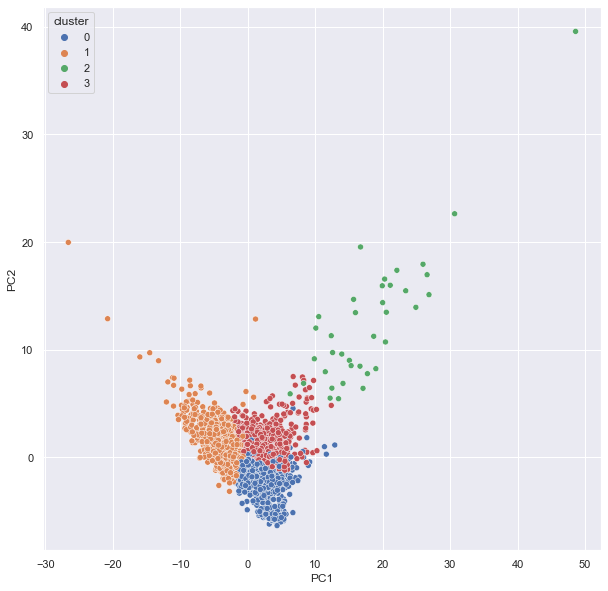

In [104]:
pca = PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 

pca_data['cluster'] = pd.Categorical(kmeans.labels_)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data)



We see here that ARI is pretty close to 0 which means that we do not have a very strong model.  We believe that this is because there is not much overlap between our clusters.  Contrary to popular belief, kmeans performs better when certain degree of overlap exists in the data.

In [105]:
#count number of images for each diagnosis per cluster
new_df.groupby(['cluster_km','dx'])['image_id'].count()

cluster_km  dx 
0           bcc    233
            bkl    485
            mel    534
            nv     235
1           bcc    214
            bkl    375
            mel    398
            nv     404
2           bcc      7
            bkl      9
            mel     12
            nv       9
3           bcc     60
            bkl    230
            mel    169
            nv     452
Name: image_id, dtype: int64

We can see here that we have very uneven clusters, almost all datapoints ended up in the first cluster using kmeans ++ which is the default initialization method used above.  Next, we tried kmeans with randomly selected centroids.  We also added the timer.

In [106]:
#run k-means on the prepared dataframe
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("start Time =", current_time)


kmeans2= KMeans(n_clusters=4,init='random', random_state=0).fit(X)

now = datetime.now()

end_time = now.strftime("%H:%M:%S")
print("end Time", end_time)

start Time = 20:51:07
end Time 20:51:07


In [107]:
#create a new column in the original dataframe to add cluster number
new_df["cluster_km_random"] = kmeans2.labels_


In [147]:
#adjusted Rand test
g=new_df['dx']
h=kmeans2.labels_
adjusted_rand_score(g,h)

0.029755074335500672

Changing the initialization method did not make much difference to the accuracy, we also wanted to see whether increasing the number of iterations would result in a better accuracy.  We increased the number of iterations to 100 based on the benchmarking study by Pasi Franti & Sami Sieranoja

In [109]:
#run k-means on the prepared dataframe
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("start Time =", current_time)

kmeans3= KMeans(n_clusters=4,init='random', n_init=100, random_state=0).fit(X)

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("end Time =", current_time)

start Time = 20:51:07
end Time = 20:51:09


In [110]:
i=kmeans3.labels_
j=new_df['dx']
adjusted_rand_score(j, i)

0.029834197804427528

Still no improvement.  Another option is to assign the centroids manually by taking a representative image from each diagnosis. This is what we tried next: <br>
*Based on the literature for scikit_learn, to mannually set the centroids, we pass an array of dimentions n_clusters,n_features to the kmeans function <br>
*First we reviewed the images folder to find a representative image for each dx <br>
*Then we located an index number in the new_df by subsetting on image_id we wanted  <br>
*Next, we used those index numbers to subset the new_df3 (which is the final dataframe prepped for kmeans) <br>
*Finally we turned that subset into an array needed for kmeans <br>

In [111]:
new_df[new_df['image_id']=="ISIC_0028155"]


,lesion_id,image_id,dx,dx_type,age,sex,localization,RGB,GrayScale,diss_sim_0,...,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7,cluster_km,cluster_km_random
2462,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,"[23, 17, 22, 18, 13, 15, 21, 15, 20, 22, 17, 1...","[19, 14, 17, 18, 17, 17, 19, 21, 18, 17, 17, 1...",1.858333,...,5.963889,6.483333,160.152778,6.738889,9.172222,9.3,6.916667,6.941667,1,1


In [112]:
new_df[new_df['image_id']=="ISIC_0029450"]


,lesion_id,image_id,dx,dx_type,age,sex,localization,RGB,GrayScale,diss_sim_0,...,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7,cluster_km,cluster_km_random
8248,HAM_0004239,ISIC_0029450,nv,histo,75.0,female,lower extremity,"[177, 169, 222, 181, 173, 226, 179, 173, 226, ...","[186, 190, 190, 193, 195, 198, 199, 198, 197, ...",3.538889,...,20.783333,22.113889,24.319444,23.302778,17.238889,18.405556,16.580556,15.577778,0,3


In [113]:
new_df[new_df['image_id']=="ISIC_0026769"]


,lesion_id,image_id,dx,dx_type,age,sex,localization,RGB,GrayScale,diss_sim_0,...,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7,cluster_km,cluster_km_random
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,"[140, 128, 186, 136, 128, 188, 133, 126, 183, ...","[147, 147, 144, 147, 149, 151, 152, 155, 157, ...",2.227778,...,7.977778,26.869444,10.6,11.488889,15.966667,18.802778,11.638889,11.772222,0,3


In [114]:
new_df[new_df['image_id']=="ISIC_0030623"]

,lesion_id,image_id,dx,dx_type,age,sex,localization,RGB,GrayScale,diss_sim_0,...,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7,cluster_km,cluster_km_random
1212,HAM_0000871,ISIC_0030623,mel,histo,40.0,female,chest,"[192, 172, 201, 189, 171, 202, 188, 172, 203, ...","[183, 182, 183, 183, 181, 182, 183, 183, 183, ...",1.575,...,4.186111,4.725,5.075,3.994444,3.891667,5.641667,4.941667,3.113889,1,1


In [115]:
centroids = new_df3.loc[[2462,8248,2,1212], :]
centroids

,diss_sim_0,diss_sim_1,diss_sim_2,diss_sim_3,diss_sim_4,diss_sim_5,diss_sim_6,diss_sim_7,corr_0,corr_1,...,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7,sex_cat,loc_cat
2462,1.858333,1.905556,11.375000,1.955556,2.188889,2.200000,1.966667,2.019444,0.453716,0.640727,...,5.963889,6.483333,160.152778,6.738889,9.172222,9.300000,6.916667,6.941667,1,2
8248,3.538889,3.813889,3.441667,3.863889,3.283333,3.444444,3.291667,3.072222,0.630247,0.634096,...,20.783333,22.113889,24.319444,23.302778,17.238889,18.405556,16.580556,15.577778,0,9
2,2.227778,4.308333,2.650000,2.750000,3.033333,3.436111,2.650000,2.777778,0.816548,0.801455,...,7.977778,26.869444,10.600000,11.488889,15.966667,18.802778,11.638889,11.772222,1,11
1212,1.575000,1.680556,1.658333,1.550000,1.519444,1.852778,1.697222,1.352778,0.508783,0.485074,...,4.186111,4.725000,5.075000,3.994444,3.891667,5.641667,4.941667,3.113889,0,3


In [116]:
centroids_array=np.array(centroids)

In [117]:
kmeans4= KMeans(n_clusters=4,init= centroids_array).fit(X)

C:\Users\Tanja\anaconda3\envs\CPSC_4830\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [118]:
kmeans4.labels_

array([0, 0, 0, ..., 3, 3, 3])

In [119]:
k=kmeans4.labels_
l=new_df['dx']
adjusted_rand_score(k,l)

0.0034601030350937534

## RUN DEEP LEARNING ALGORITHMS FOR FEATURE SELECTION

# MobileNetV2 from Keras

In [120]:
#import required libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import cv2
import os, glob, shutil

In [121]:
#import images
input_dir = 'images2'
glob_dir = input_dir + '/*.jpg'
images = [cv2.resize(cv2.imread(file), (224, 224)) for file in glob.glob(glob_dir)]
paths = [file for file in glob.glob(glob_dir)]
images = np.array(np.float32(images).reshape(len(images), -1)/255)

In [122]:
#extract features
model = tf.keras.applications.MobileNetV2(include_top=False,
weights="imagenet", input_shape=(224, 224, 3))
predictions = model.predict(images.reshape(-1, 224, 224, 3))
pred_images = predictions.reshape(images.shape[0], -1)

In [123]:
#run k-means and save respective images for each cluster in a separate folder
k = 4
kmodel = KMeans(n_clusters = k, n_jobs=-1, random_state=728)
kmodel.fit(pred_images)
kpredictions = kmodel.predict(pred_images)
shutil.rmtree('output')
for i in range(k):
    os.makedirs('output\cluster' + str(i))
for i in range(len(paths)):
    shutil.copy2(paths[i], 'output\cluster'+str(kpredictions[i]))

C:\Users\Tanja\anaconda3\envs\CPSC_4830\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [124]:
#create a dataframe with filename and cluster label
image_cluster_mobilenetV2 = pd.DataFrame(paths,columns=['image'])
image_cluster_mobilenetV2["cluster_mnet"] = kpredictions
image_cluster_mobilenetV2

,image,cluster_mnet
0,images2\ISIC_0024309.jpg,2
1,images2\ISIC_0024310.jpg,2
2,images2\ISIC_0024312.jpg,1
3,images2\ISIC_0024313.jpg,3
4,images2\ISIC_0024314.jpg,1
...,...,...
3821,images2\ISIC_0034315.jpg,0
3822,images2\ISIC_0034316.jpg,2
3823,images2\ISIC_0034317.jpg,3
3824,images2\ISIC_0034318.jpg,3


In [125]:
#strip additional characters from filename to get image ids
image_cluster_mobilenetV2['image_id']=image_cluster_mobilenetV2['image'].str[8:-4]

image_cluster_mobilenetV2.head()

,image,cluster_mnet,image_id
0,images2\ISIC_0024309.jpg,2,ISIC_0024309
1,images2\ISIC_0024310.jpg,2,ISIC_0024310
2,images2\ISIC_0024312.jpg,1,ISIC_0024312
3,images2\ISIC_0024313.jpg,3,ISIC_0024313
4,images2\ISIC_0024314.jpg,1,ISIC_0024314


In [126]:
image_cluster_mobilenetV2.drop('image', axis=1, inplace=True)

In [127]:
#save this into csv file so we don't have to run it each time
#image_cluster_mobilenetV2.to_csv("CNN clusters MobileNetV2.csv")

In [128]:
#import output file from the CNN feature extraction
#clusters=pd.read_csv('CNN clusters MobileNetV2.csv')

In [129]:
#apend cluster numbers to dataframe with metadata (ground truth)
test_clusters=pd.merge(new_df,image_cluster_mobilenetV2, how="left", on='image_id')
test_clusters.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,RGB,GrayScale,diss_sim_0,...,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7,cluster_km,cluster_km_random,cluster_mnet
0,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,"[23, 17, 22, 18, 13, 15, 21, 15, 20, 22, 17, 1...","[19, 14, 17, 18, 17, 17, 19, 21, 18, 17, 17, 1...",1.858333,...,6.483333,160.152778,6.738889,9.172222,9.300000,6.916667,6.941667,1,1,0
1,HAM_0003220,ISIC_0034093,bcc,histo,80.0,female,face,"[194, 172, 196, 198, 175, 190, 201, 174, 194, ...","[182, 182, 183, 185, 182, 183, 184, 182, 185, ...",1.050000,...,3.477778,2.269444,1.747222,3.030556,3.852778,2.705556,2.586111,1,1,2
2,HAM_0007141,ISIC_0029230,bcc,histo,50.0,male,trunk,"[201, 178, 186, 202, 179, 187, 202, 180, 185, ...","[183, 184, 184, 183, 183, 183, 182, 182, 183, ...",1.116667,...,2.000000,1.877778,2.172222,2.075000,3.108333,2.508333,2.463889,1,1,2
3,HAM_0007141,ISIC_0031513,bcc,histo,50.0,male,trunk,"[22, 12, 18, 20, 12, 19, 22, 12, 18, 23, 12, 2...","[15, 15, 15, 16, 16, 17, 20, 21, 24, 28, 33, 3...",1.322222,...,3.822222,17.461111,2.802778,2.791667,2.325000,4.352778,2.619444,1,1,0
4,HAM_0007009,ISIC_0032384,bcc,histo,50.0,male,back,"[211, 198, 222, 210, 197, 221, 209, 196, 220, ...","[207, 206, 205, 206, 205, 206, 207, 205, 206, ...",1.536111,...,4.572222,4.022222,4.747222,53.052778,22.761111,30.475000,41.169444,1,1,2


In [130]:
#count number of images for each diagnosis per cluster
test_clusters.groupby(['cluster_mnet','dx'])['image_id'].count()

cluster_mnet  dx 
0             bcc     27
              bkl    126
              mel    137
              nv      60
1             bcc    148
              bkl    272
              mel    216
              nv     314
2             bcc    238
              bkl    487
              mel    440
              nv     268
3             bcc    101
              bkl    214
              mel    320
              nv     458
Name: image_id, dtype: int64

In [131]:
#adjusted Rand test
a=test_clusters['dx']
b=test_clusters['cluster_mnet']
adjusted_rand_score(a,b)

0.020673571137004503

We see a small improvement in ARI score by employing CNN for feature selection and then kmeans for classification

# InceptionV3 from Keras

In [132]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import shutil

In [133]:
# Function to Extract features from the images
def image_feature(direc):
    model2 = InceptionV3(weights='imagenet', include_top=False)
    features = [];
    img_name = [];
    for i in tqdm(direc):
        fname='images2'+'/'+i
        img=image.load_img(fname,target_size=(224,224))
        x = img_to_array(img)
        x=np.expand_dims(x,axis=0)
        x=preprocess_input(x)
        feat=model.predict(x)
        feat=feat.flatten()
        features.append(feat)
        img_name.append(i)
    return features,img_name

In [134]:
img_path=os.listdir('images2')
img_features,img_name=image_feature(img_path)

100%|██████████████████████████████████████████████████████████████████████████████| 3826/3826 [07:02<00:00,  9.05it/s]


In [135]:
#Creating Clusters
k = 4
clusters = KMeans(k, random_state = 728)
clusters.fit(img_features)

KMeans(n_clusters=4, random_state=728)

In [136]:
#add a column to dataframe with cluster labels
image_cluster = pd.DataFrame(img_name,columns=['images'])
image_cluster["cluster_incep"] = clusters.labels_
image_cluster.head() 

,images,cluster_incep
0,ISIC_0024309.jpg,0
1,ISIC_0024310.jpg,1
2,ISIC_0024312.jpg,2
3,ISIC_0024313.jpg,3
4,ISIC_0024314.jpg,2


In [137]:
#chop of the last 4 characters (.jpg) from image name and create a new column to save them in
image_cluster['image_id']=image_cluster['images'].str[:-4]

image_cluster.head()

,images,cluster_incep,image_id
0,ISIC_0024309.jpg,0,ISIC_0024309
1,ISIC_0024310.jpg,1,ISIC_0024310
2,ISIC_0024312.jpg,2,ISIC_0024312
3,ISIC_0024313.jpg,3,ISIC_0024313
4,ISIC_0024314.jpg,2,ISIC_0024314


In [138]:
#drop the original column with file names
image_cluster.drop('images', axis=1, inplace=True)

In [139]:
#save dataframe to csv for later use
#image_cluster.to_csv("CNN clusters InceptionV3.csv")

In [140]:
#import output file from the CNN feature extraction
#clusters2=pd.read_csv('CNN clusters InceptionV3.csv')

In [141]:
#apend cluster numbers to dataframe with metadata (ground truth)
test_clusters2=pd.merge(new_df,image_cluster, how="left", on='image_id')
test_clusters2

,lesion_id,image_id,dx,dx_type,age,sex,localization,RGB,GrayScale,diss_sim_0,...,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7,cluster_km,cluster_km_random,cluster_incep
0,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,"[23, 17, 22, 18, 13, 15, 21, 15, 20, 22, 17, 1...","[19, 14, 17, 18, 17, 17, 19, 21, 18, 17, 17, 1...",1.858333,...,6.483333,160.152778,6.738889,9.172222,9.300000,6.916667,6.941667,1,1,1
1,HAM_0003220,ISIC_0034093,bcc,histo,80.0,female,face,"[194, 172, 196, 198, 175, 190, 201, 174, 194, ...","[182, 182, 183, 185, 182, 183, 184, 182, 185, ...",1.050000,...,3.477778,2.269444,1.747222,3.030556,3.852778,2.705556,2.586111,1,1,1
2,HAM_0007141,ISIC_0029230,bcc,histo,50.0,male,trunk,"[201, 178, 186, 202, 179, 187, 202, 180, 185, ...","[183, 184, 184, 183, 183, 183, 182, 182, 183, ...",1.116667,...,2.000000,1.877778,2.172222,2.075000,3.108333,2.508333,2.463889,1,1,0
3,HAM_0007141,ISIC_0031513,bcc,histo,50.0,male,trunk,"[22, 12, 18, 20, 12, 19, 22, 12, 18, 23, 12, 2...","[15, 15, 15, 16, 16, 17, 20, 21, 24, 28, 33, 3...",1.322222,...,3.822222,17.461111,2.802778,2.791667,2.325000,4.352778,2.619444,1,1,1
4,HAM_0007009,ISIC_0032384,bcc,histo,50.0,male,back,"[211, 198, 222, 210, 197, 221, 209, 196, 220, ...","[207, 206, 205, 206, 205, 206, 207, 205, 206, ...",1.536111,...,4.572222,4.022222,4.747222,53.052778,22.761111,30.475000,41.169444,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3821,HAM_0001953,ISIC_0025611,mel,histo,65.0,male,back,"[165, 150, 178, 165, 150, 178, 166, 152, 180, ...","[160, 160, 162, 162, 163, 164, 165, 165, 165, ...",3.511111,...,8.041667,3.113889,19.944444,5.850000,4.358333,6.588889,3.741667,0,3,3
3822,HAM_0002552,ISIC_0032985,mel,histo,25.0,male,upper extremity,"[241, 225, 242, 242, 228, 240, 247, 233, 245, ...","[232, 233, 238, 242, 239, 240, 241, 239, 238, ...",2.883333,...,14.766667,8.777778,12.622222,17.247222,14.894444,8.669444,17.466667,0,3,3
3823,HAM_0002552,ISIC_0032936,mel,histo,25.0,male,upper extremity,"[226, 208, 215, 229, 209, 214, 229, 210, 213, ...","[212, 213, 213, 214, 214, 213, 213, 212, 211, ...",2.319444,...,9.236111,5.719444,7.227778,8.383333,6.308333,14.283333,12.325000,0,3,2
3824,HAM_0002552,ISIC_0033232,mel,histo,25.0,male,upper extremity,"[208, 202, 221, 208, 202, 221, 204, 202, 221, ...","[208, 208, 208, 209, 210, 207, 209, 204, 206, ...",2.397222,...,7.319444,10.044444,7.525000,12.622222,11.336111,10.275000,10.094444,0,3,3


In [142]:
#count number of images for each diagnosis per cluster
test_clusters2.groupby(['cluster_incep','dx'])['image_id'].count()

cluster_incep  dx 
0              bcc    239
               bkl    478
               mel    290
               nv     259
1              bcc    101
               bkl    248
               mel    258
               nv      82
2              bcc    124
               bkl    202
               mel    139
               nv     299
3              bcc     50
               bkl    171
               mel    426
               nv     460
Name: image_id, dtype: int64

In [143]:
#adjusted Rand test
c=test_clusters2['dx']
d=test_clusters2['cluster_incep']
adjusted_rand_score(c,d)

0.044897047985328

Here we are seeing further improvement in the ARI.

# Next steps

1.  Create visualizations of various clusters
2.  Optimize kmeans arguments to try to achieve better separation
3.  Assign centers manually and see if this can improve classification
4.  Insert timer in the cells where various kmeans models are run to time the execution (%%timeit)
6.  Run supervised ML models such as logistic regression, random forest or neural networks and compare accuracy

References: <br>
1. Marcos A. M. Almeida, and Iury A. X. Santos, Classification Models for Skin Tumor Detection Using Texture Analysis in Medical Images, Journal of Imaging,  Published: 19 June 2020 <br>
2. P. Mohanaiah, P. Sathyanarayana, L. GuruKumar, Image Texture Feature Extraction Using GLCM Approach, International Journal of Scientific and Research Publications, Volume 3, Issue 5, May 2013 <br>
3. S. Bhattiprolu, Python for Microscopists, taken from github and youtube, https://github.com/bnsreenu/python_for_microscopists <br>
4. H. Castillejos-Fernándeza, O. López-Ortegaa, F. Castro-Espinozaa and V. Ponomaryovb, An Intelligent System for the Diagnosis of Skin Cancer on Digital Images taken with Dermoscopy, Acta Polytechnica Hungarica, Vol. 14, No. 3, 2017 <br>
5. J. Hayes, Image Classification -Gray Level Co-Occurrence Matrix (GLCM), http://web.pdx.edu/~jduh/courses/Archive/geog481w07/Students/Hayes_GreyScaleCoOccurrenceMatrix.pdf, last accessed 10/30/21 
6.  H.Patel, Using K-means clustering for image seggregation, last accesed 11/09/2021 https://towardsdatascience.com/using-k-means-clustering-for-image-segregation-fd80bea8412d
7.  https://keras.io/api/applications/mobilenet/
8.  https://keras.io/api/applications/inceptionv3/
9.  S. Gupta, Image clustering using Kmeans, last accesses 11/09/2021 https://towardsdatascience.com/image-clustering-using-k-means-4a78478d2b83


Prepared by: Annie Li, Tanja Jancic-Turner, Jose Tellez and Chan Shek (Tom)